In [3]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq, eigh, norm
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import hbar, elementary_charge, speed_of_light, Boltzmann

from itertools import product
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [37]:
"""
Call an instance of BEC to get physical params. This way wavelengths may be set precisely for dimensionless units
"""
# Determine the ratio of target wavelength / minimum achievable wavelength 
sub_λ_factor = 0.25  
# Determine the percentage of the wavelength to deviate by. This assumes even spacing between pulses
λ_spacing = 0.005
# Frequency of targeted atomic transition (in this case D1 line) goes here.
principal_wavelength = 794.978851e-9
# Resonance frequency of the D1 atomic transition in units of 2π Hz to keep units consistent
ω_0 = 2 * np.pi * speed_of_light / principal_wavelength
ω_x = 0.5 * 2 * np.pi 
ω_yz = 50 * 2 * np.pi
N = 1e3
print(f'Resonance Frequency is: 2π * {(ω_0/(2*np.pi)) * 1e-12} THz')

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_yz,
    omega_z=ω_yz,
    number_of_atoms=N,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g

"""
Define default params and use the default utility for saving
"""
# Number of pulses
n = 4
# Determine the error tolerance
eps = 1e-11
# Now declare the pulse parameters, starting with the wavelength closest to the transition
λ_min = (1+λ_spacing) * gpe.dimless_x(principal_wavelength)
# Max wave
k_max = 2 * np.pi / λ_min
λ_array = [λ_min+_*λ_spacing for _ in range(0, n)]
ampl = np.sqrt(gpe.dimless_energy(50, -9)) # This ensures that the square of the amplitude should result in roughly 100 nanokelvin

λ = λ_min * sub_λ_factor
print(f'Target λ is {λ} in dimensionless units')
k = 2 * np.pi / λ
x_win = np.pi/(2 * k)
x_lim = gpe.dimless_x(gpe.L_x) / 2
x_res = 2 ** 16
dx = 2. * x_lim / x_res


named_params = {
    'tgt_wavelength': round(λ, 2),
    'shortest_wlen':round(λ_min, 6),
    'tgt_amplitutde':round(ampl, 2),
    'pulses': n,
    'min_wlen': round(λ_min, 2),
    'wlen_spacing': round(λ_spacing, 6),
}
params = copy.deepcopy(named_params)
file_path, file_name= utlt.build_saves_tag(params_list=named_params, unique_identifier='Paper_Single-Well', parent_directory='Archive_Data/Superoscilations')
ok = utlt.standardize_plots(plt.rcParams)


Resonance Frequency is: 2π * 377.10746345376674 THz
Target λ is 0.013096519030793615 in dimensionless units
Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

Simulation Directory "Paper_Single-Well-tgt_wavelength0,01-shortest_wlen0,052386-tgt_amplitutde45,65-pulses4-min_wlen0,05-wlen_spacing0,005" created


In [47]:
print(f'The conversion factor for dimensionless energy {gpe.dimless_energy(1, -9)}')
print(f'The target potential amplitude is {round(gpe.convert_energy(ampl ** 2, -9), 2)} nK, or ~{round(ampl ** 2, 2)} in dimensionless units.')
print(f'The characteristic length, L_x is {gpe.L_x *1e6} μm')
print(f'The transverse characteristic length, L_y, L_z is {gpe.L_y *1e6} μm')
print(f'The shortest wavelength for this for this run is {gpe.convert_x(λ_min, -9)} nm')


The conversion factor for dimensionless energy 41.67323824665515
The target potential amplitude is 50.0 nK, or ~2083.66 in dimensionless units.
The characteristic length, L_x is 15.25126148743101 μm
The transverse characteristic length, L_y, L_z is 1.5251261487431012 μm
The shortest wavelength for this for this run is 798.953745255 nm


In [72]:
# Get the contant prefactor for α in dimensionless units.
# (elementary_charge^2 order e-38) / (mass order e-25, hbar order e-34)
# comes out to 1e-38 / 1e-59, or 1e21 after everything, round to 8 digits because of precision
α = round(1e21 * (1.602176634 ** 2 * 1.380649)/ (1.44316060 * 1.054571817 * ω_x), 8)

In [73]:
def Phi(space, wave_vector, phase=0, amplitude=1):
    return amplitude * np.sin(wave_vector * space + phase)

def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)

def Phi_combine(A, B, wave_vector, space):
    amplitude = np.sqrt(A ** 2 + B ** 2)
    phase = np.angle(A + 1j * B)
    single_field = amplitude * np.cos(wave_vector * space - phase)
    return amplitude, phase, single_field

def field_to_V_scaling(wavelength):
    # because the wavelength has already been coverted to dimensionless units, we need to temporarily convert it back to get the frequency
    # This is because α has already been 
    frequency = 2 * np.pi * speed_of_light / gpe.convert_x(wavelength, 0)
    return 0.5 * α / (ω_0 ** 2 - frequency ** 2)
    
    

In [74]:
testa = np.arange(0, 2*n, 1)
test_info = [Phi_combine(testa[_], testa[_+1], __, x) for _, __ in zip(np.arange(0, 2*n-1, 2), 2 * np.pi * np.array(λ_array) ** -1)]
test1, test2, test3 = [[_[__] for _ in test_info] for __ in range(0, len(test_info)-1)]
test_full_field=np.sum(test3, axis=0)

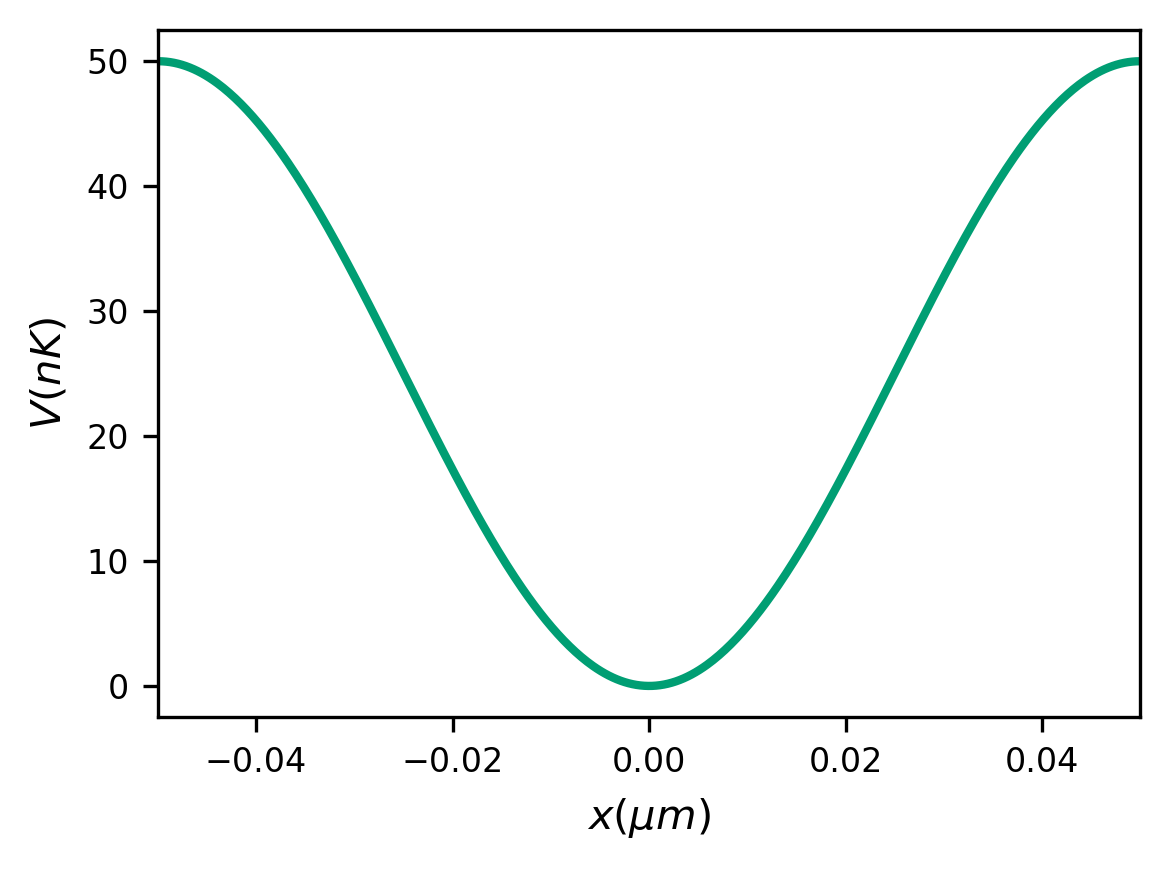

In [75]:
x = np.linspace(-x_win, x_win, 500)
x_units = gpe.convert_x(x, -6)
zoom_out_x = (np.arange(x_res) - x_res / 2) * dx
target_barrier = Phi(x, k, amplitude = ampl, phase=0)
plt.plot(x_units , gpe.convert_energy(target_barrier  ** 2 , -9), color=ok['green'])
plt.xlabel('$x (\mu m)$')
plt.ylabel('$V (nK)$')
plt.xlim(x_units[0], x_units[-1])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Init_Potential.pdf')
plt.show()

In [76]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# New array for time
# Set
workers = 64
# Number of initial guesses per thread
init_guess_n = workers * 20


seed = np.random.default_rng(2024)
# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Phase
    seed.uniform(-2*np.pi, 2*np.pi, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 100, (init_guess_n, n))
])

freqs = 2 * np.pi * (np.array(λ_array) ** (-1))

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

print(f'Frequencies are: {freqs}')
print(f'Wavelengths are: {λ_array}')

# Define the constraints
phase_lims = (-2 * np.pi, 2 * np.pi)           # Time delay constrained to be positive
ampl_lims = (0, None)      # Some constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # Phase limits
    np.full((n, 2), phase_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])

initial_guess_alt = np.hstack([
    # Phase
    seed.uniform(1, 20, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

# Define the constraints
ai_lims = (0, None)
bi_lims = (0, None)


# Create the array of bounds for the best fit minimization
bnds_alt = np.concatenate([
    # Phase limits
    np.full((n, 2), ai_lims),
    # Amplitude limits
    np.full((n, 2), bi_lims)
])


Number of Pulses: 4
Length of x: 1280
Frequencies are: [119.93998734 109.48971827 100.71454558  93.24159632]
Wavelengths are: [0.05238607612317446, 0.05738607612317446, 0.06238607612317446, 0.06738607612317446]


In [77]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(f):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(f), 2)
    assert res == 0
    phases = f[:length]
    amplitudes = f[length:(2 * length)]
    
    return phases, amplitudes

def phi_func(f, t):
    phase, amplitude = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi(t, i, j, k) for i, j, k in zip(freqs, phase, amplitude))

def obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



def phi_func_alt(f, t):
    ai, bi = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi_transform(t, i, j, k) for i, j, k in zip(freqs, ai, bi))

def obj_alt(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func_alt(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds_alt,
        tol=eps
    )
    return result.fun, result.x



In [78]:
def super_obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x)) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x

In [79]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    with Pool(processes=workers) as pool:
        result = pool.map(obj, initial_guess)
        #result_super = pool.map(super_obj, initial_guess)
        #result_alt = pool.map(obj_alt, initial_guess_alt)

Amplitudes here are: [-3.1415926583601355, 6.283184991340459, 15755.998746753228, 0.003058969027042218]
Prefactors for each field are: [6.65106401e-09 3.77362803e-10 2.18673229e-10 1.64362050e-10]


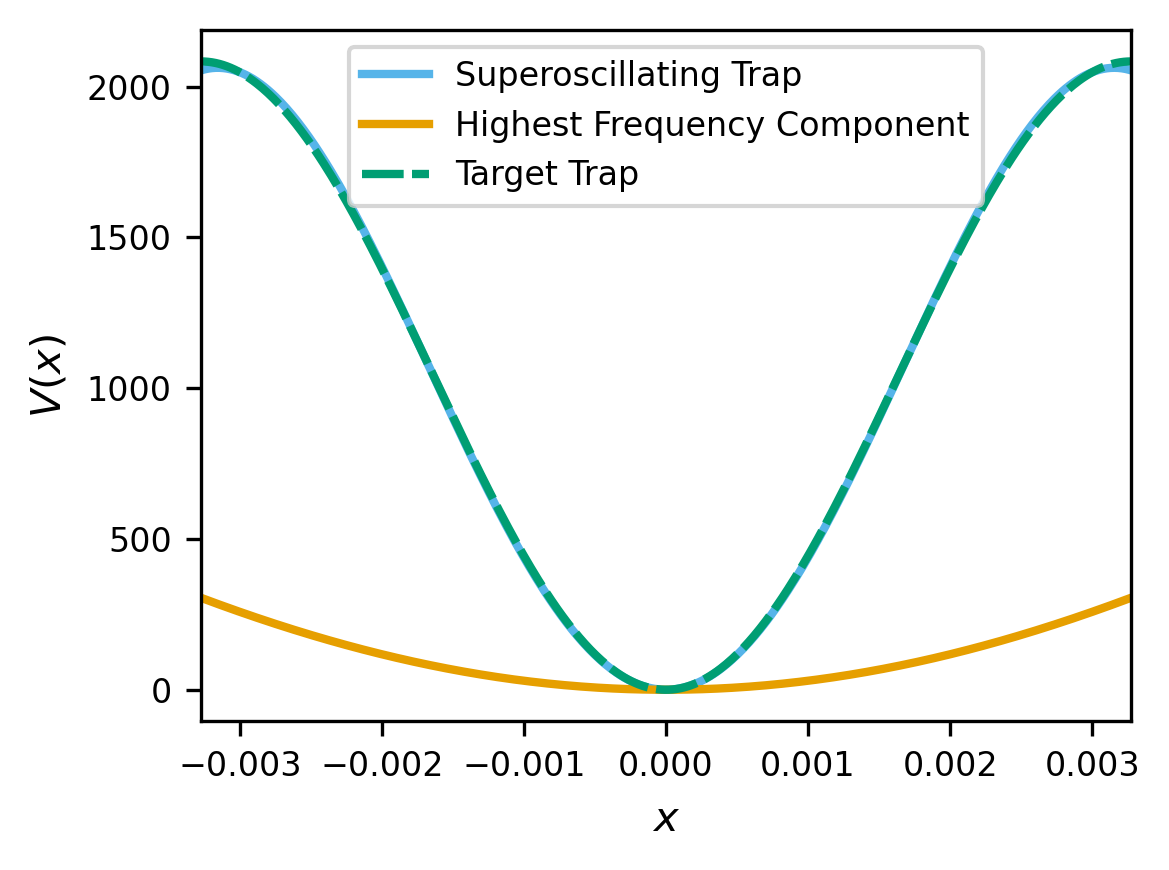

In [80]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals, x)
print(f'Amplitudes here are: {[opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]}')
print(f'Prefactors for each field are: {field_to_V_scaling(λ_array)}')

plt.plot(x, best_fit ** 2 , label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest Frequency Component')
plt.plot(x, target_barrier ** 2 , linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
#plt.ylim(0, 1.1*ampl**2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results.pdf')
#plt.savefig('./Plots/Presentation/Results.pdf')
plt.show()

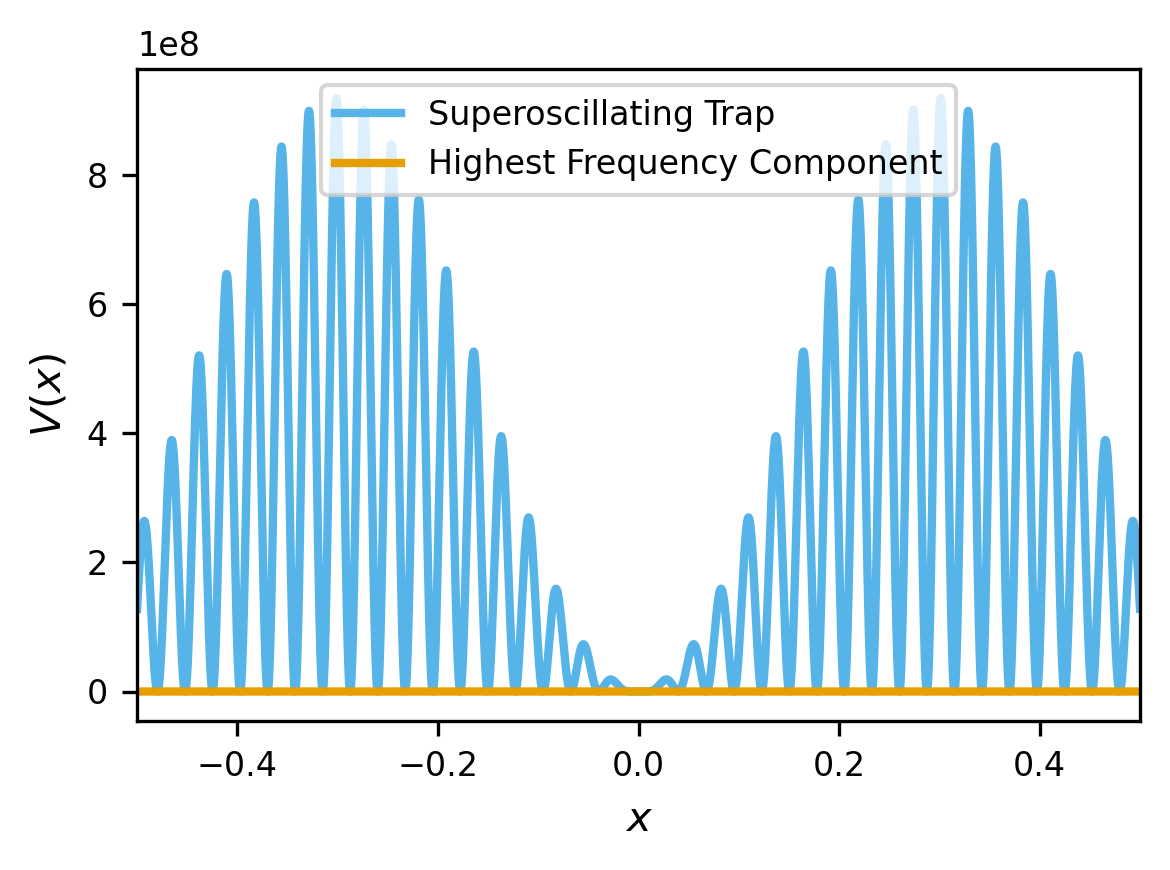

In [81]:
############################################################
#
# Show the complete potential
#
############################################################

best_fit_zoom = phi_func(opt_vals, zoom_out_x)

plt.plot(zoom_out_x, best_fit_zoom ** 2, label='Superoscillating Trap')
plt.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component')
#plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

In [412]:
##############################################################################
#
# Get the best result for minimization of the alternative objective function
# Removed but not deleted because it is useful, just not in this specific case
#
##############################################################################

#result_alt.sort(key=lambda _: _[0])
#opt_vals_alt = result_alt[0][1]
#best_fit_alt = phi_func(opt_vals_alt, x)
#best_fit_alt_zoom = phi_func(opt_vals_alt, zoom_out_x)
#print(f'Amplitudes here are: {[opt_vals_alt[_] for _ in np.arange(1, 2 * n, 2)]}')

#plt.plot(x, np.abs(best_fit_alt) ** 2, label='Superoscillating Trap')
#plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl)) ** 2, label='Highest Wave Vector Component')
#plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Trap')
#plt.xlabel('$x$')
#plt.ylabel('$ V(x)$')
#plt.xlim(x[0], x[-1])
#plt.ylim(0, 1.1*ampl**2)
#plt.legend(loc='upper center')
#plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_Results_alt.pdf')
##plt.savefig('./Plots/Presentation/Results_alt.pdf')
#plt.show()

In [413]:
############################################################
#
# Show the full potential
#
############################################################


#plt.plot(zoom_out_x, best_fit_alt_zoom ** 2, label='Superoscillating Trap')
#plt.plot(zoom_out_x, Phi(zoom_out_x, k/2, amplitude=ampl) ** 2, label='Highest Frequency Component')
##plt.plot(x, target_barrier ** 2, linestyle=(0, (5, 1)), label='Target Trap')
#plt.xlabel('$x$')
#plt.ylabel('$V(x)$')
#plt.xlim(zoom_out_x[0], zoom_out_x[-1])
#plt.legend(loc='upper center')
#plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_Results_alt_Zoomed.pdf')
##plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
#plt.show()

In [414]:
#########################################################################
#
# Fitting the fields by linear model, as it can be convexly solved
#
#########################################################################
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(zoom_out_x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

#model = linear_model.Lasso(alpha=0.0001, fit_intercept=False, tol=1e-6, max_iter=100000)
#model = linear_model.Ridge(fit_intercept=False, tol=1e-6, max_iter=100000)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(fields, target_barrier)

linear_optimized_fields = fields @ model.coef_
lo_fields_zoom = fields_zoomed @ model.coef_

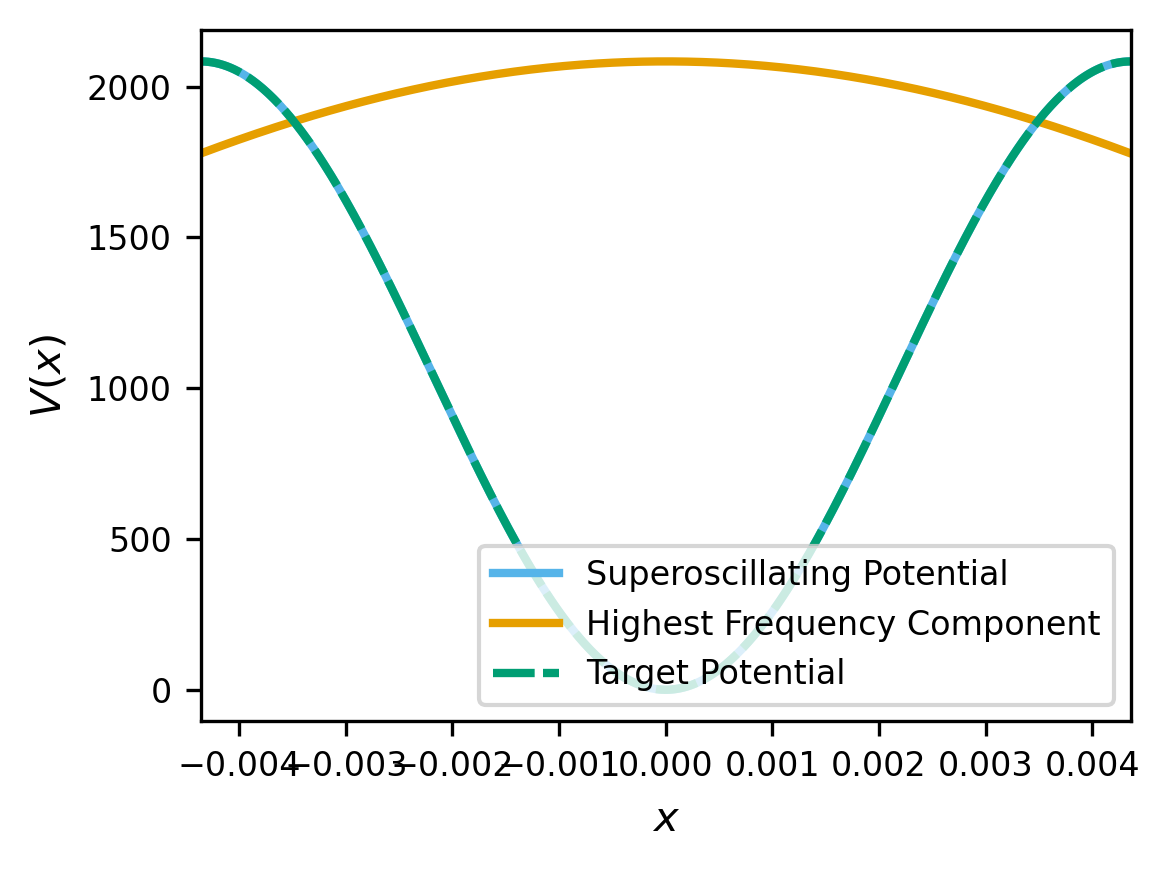

In [415]:
############################################################################
#
# Plot the results for linear optimization
#
############################################################################


plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Superoscillating Potential')
plt.plot(x, np.abs(Phi(x, k_max, amplitude=ampl, phase=np.pi/2)) ** 2, label='Highest Frequency Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
#plt.ylim(-0.025, 1.1*ampl**2)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linear.pdf')
# plt.savefig('./Plots/Presentation/Results_linear.pdf')
plt.show()

In [416]:
############################################################################
#
# Get the amplitudes of the fields used to see if they are realistic
#
############################################################################

single_func_amps = [np.sqrt((model.coef_[_]) ** 2 + (model.coef_[_+1]) ** 2) for _ in np.arange(0, len(model.coef_), 2)]
single_func_phase = [np.pi/2-np.angle(model.coef_[_ + 1] + 1j * model.coef_[_]) for _ in np.arange(0, len(model.coef_), 2)]
simplified_fields = [Phi(zoom_out_x, freqs[_], phase=single_func_phase[_], amplitude= single_func_amps[_]) for _ in range(len(freqs))]
print(f'Individual amplitudes are {model.coef_}')
print(f'Dimensionless amplitudes are {single_func_amps}')
print(f'Phases are {single_func_phase}')

#plt.plot(zoom_out_x, lo_fields_zoom, label='Comparrison Field')
#plt.plot(zoom_out_x, np.sum(simplified_fields, axis=0), '--', label='Simplified Field')
#plt.xlabel('$x$')
#plt.ylabel('$ V(x)$')
#plt.xlim(zoom_out_x[0], zoom_out_x[-1])
#plt.legend(loc='upper center')
#plt.tight_layout()
#plt.show()


Individual amplitudes are [ 1.00645160e+11 -6.42104392e+05 -3.07809602e+11  1.95528340e+06
  3.13762570e+11 -1.98449446e+06 -1.06598304e+11  6.71315458e+05]
Dimensionless amplitudes are [100645160272.33241, 307809601648.7944, 313762570079.03265, 106598303865.26645]
Phases are [-6.379883447760193e-06, 3.1415863013402667, -6.324828554893358e-06, 3.141586355971219]


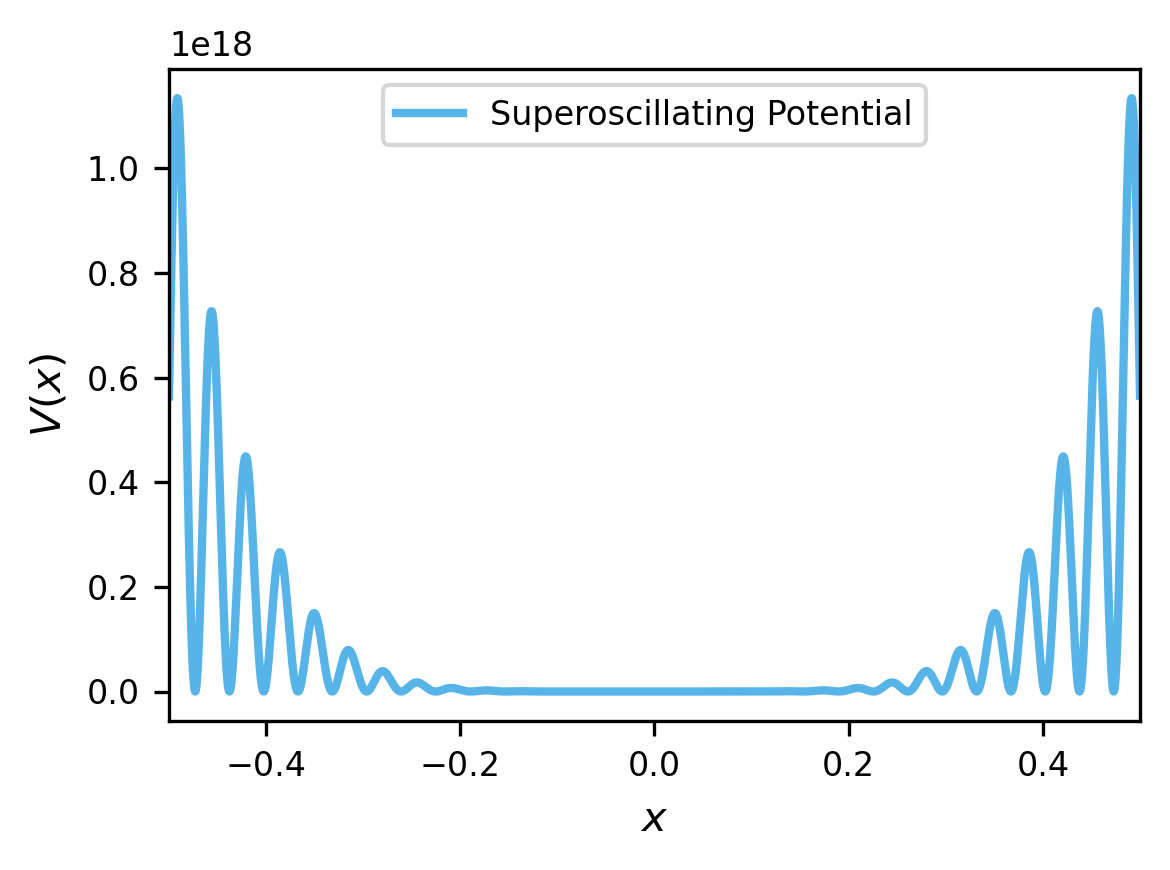

In [417]:
############################################################################
#
# Plot the zoom out of the results for linear optimization
#
############################################################################


plt.plot(zoom_out_x, np.abs(lo_fields_zoom) ** 2, label='Superoscillating Potential')
#plt.plot(zoom_out_x, np.abs(Phi(zoom_out_x, k_max, amplitude=ampl)) ** 2, label='Highest Frequency Component')
#plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(zoom_out_x[0], zoom_out_x[-1])
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linearZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

In [418]:
#########################################################################
#
# Alternate option, generating best fields by solving eigenvalue problem
#
#########################################################################
# create the overlap matrix
S = fields.T @ fields
# Solve the eigenvalue problem
vals, vecs = eigh(S)

eig_fields = [fields @ vecs[:, _] for _ in range(len(vecs[:]))]
eig_fields_zoomout = [fields_zoomed @ vecs[:, _] for _ in range(len(vecs[:]))]

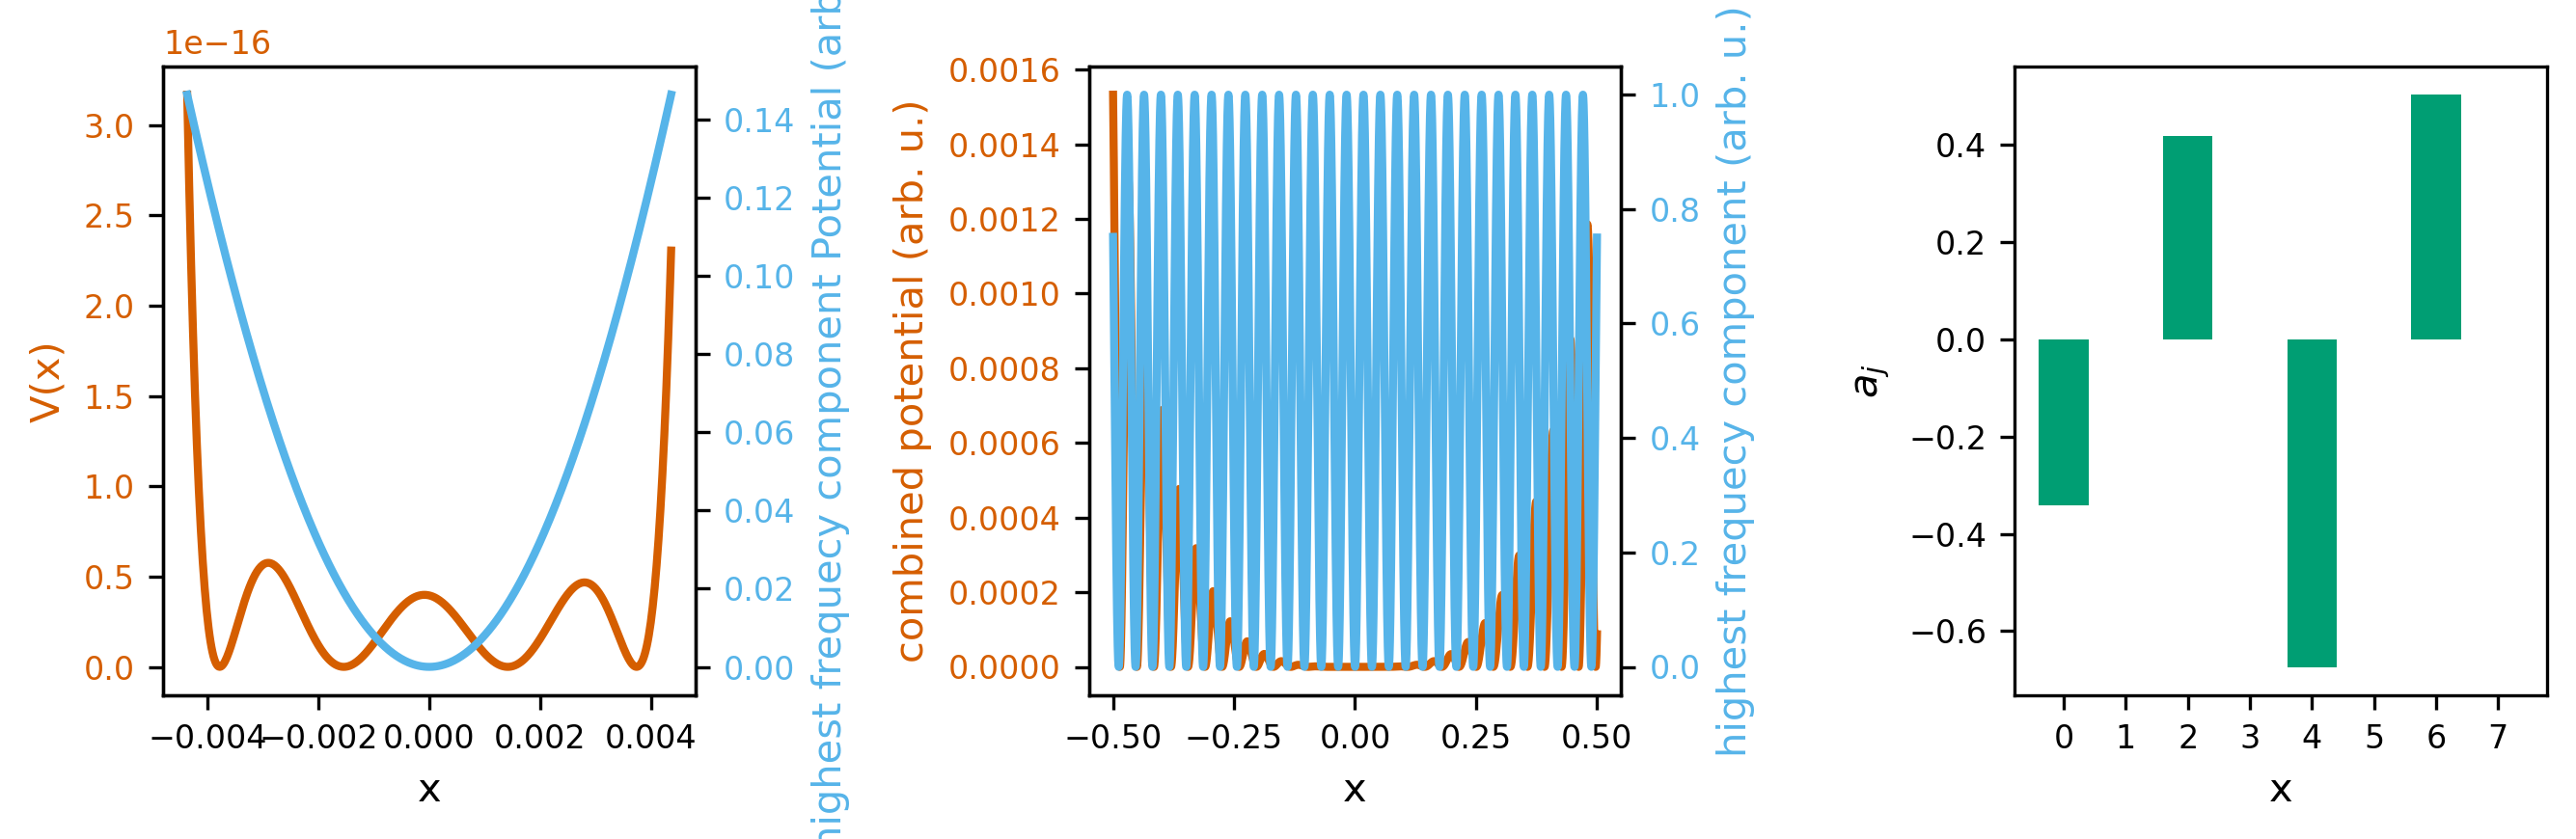

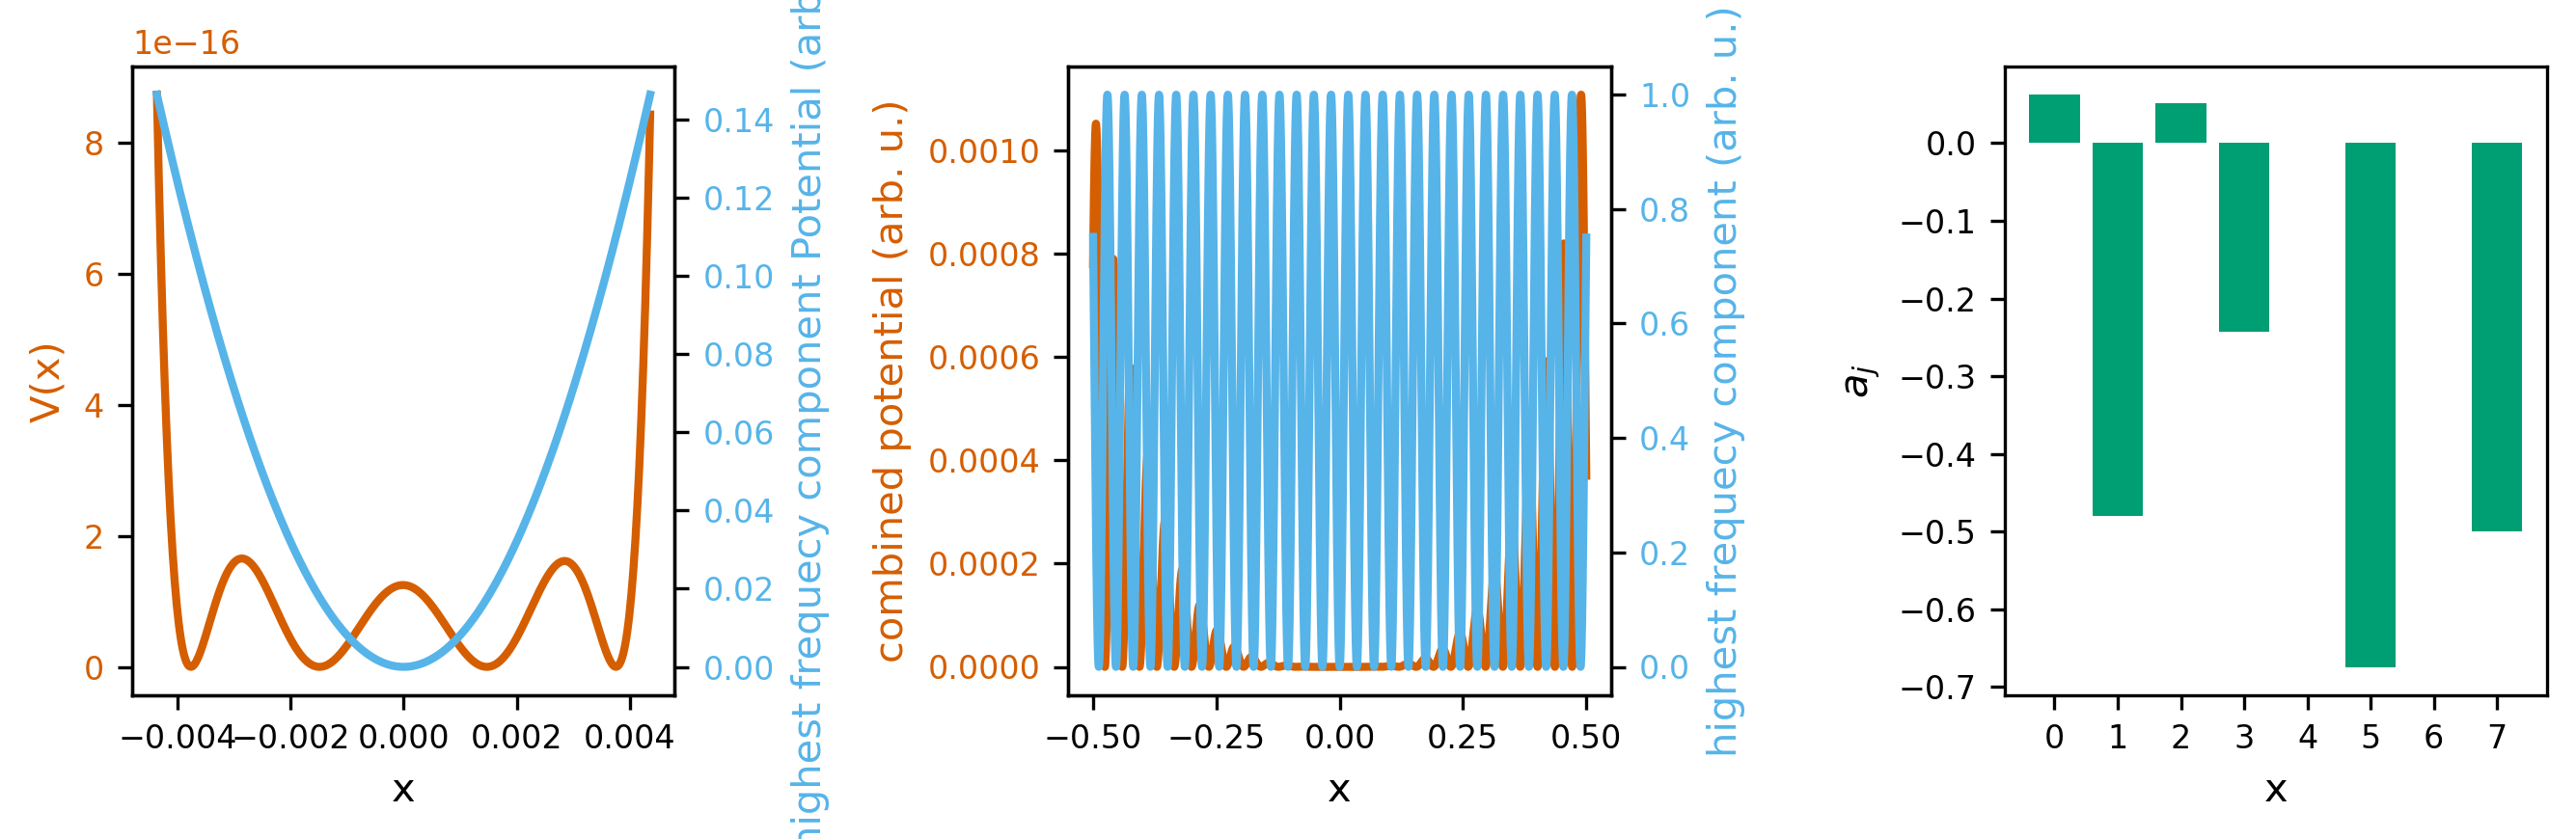

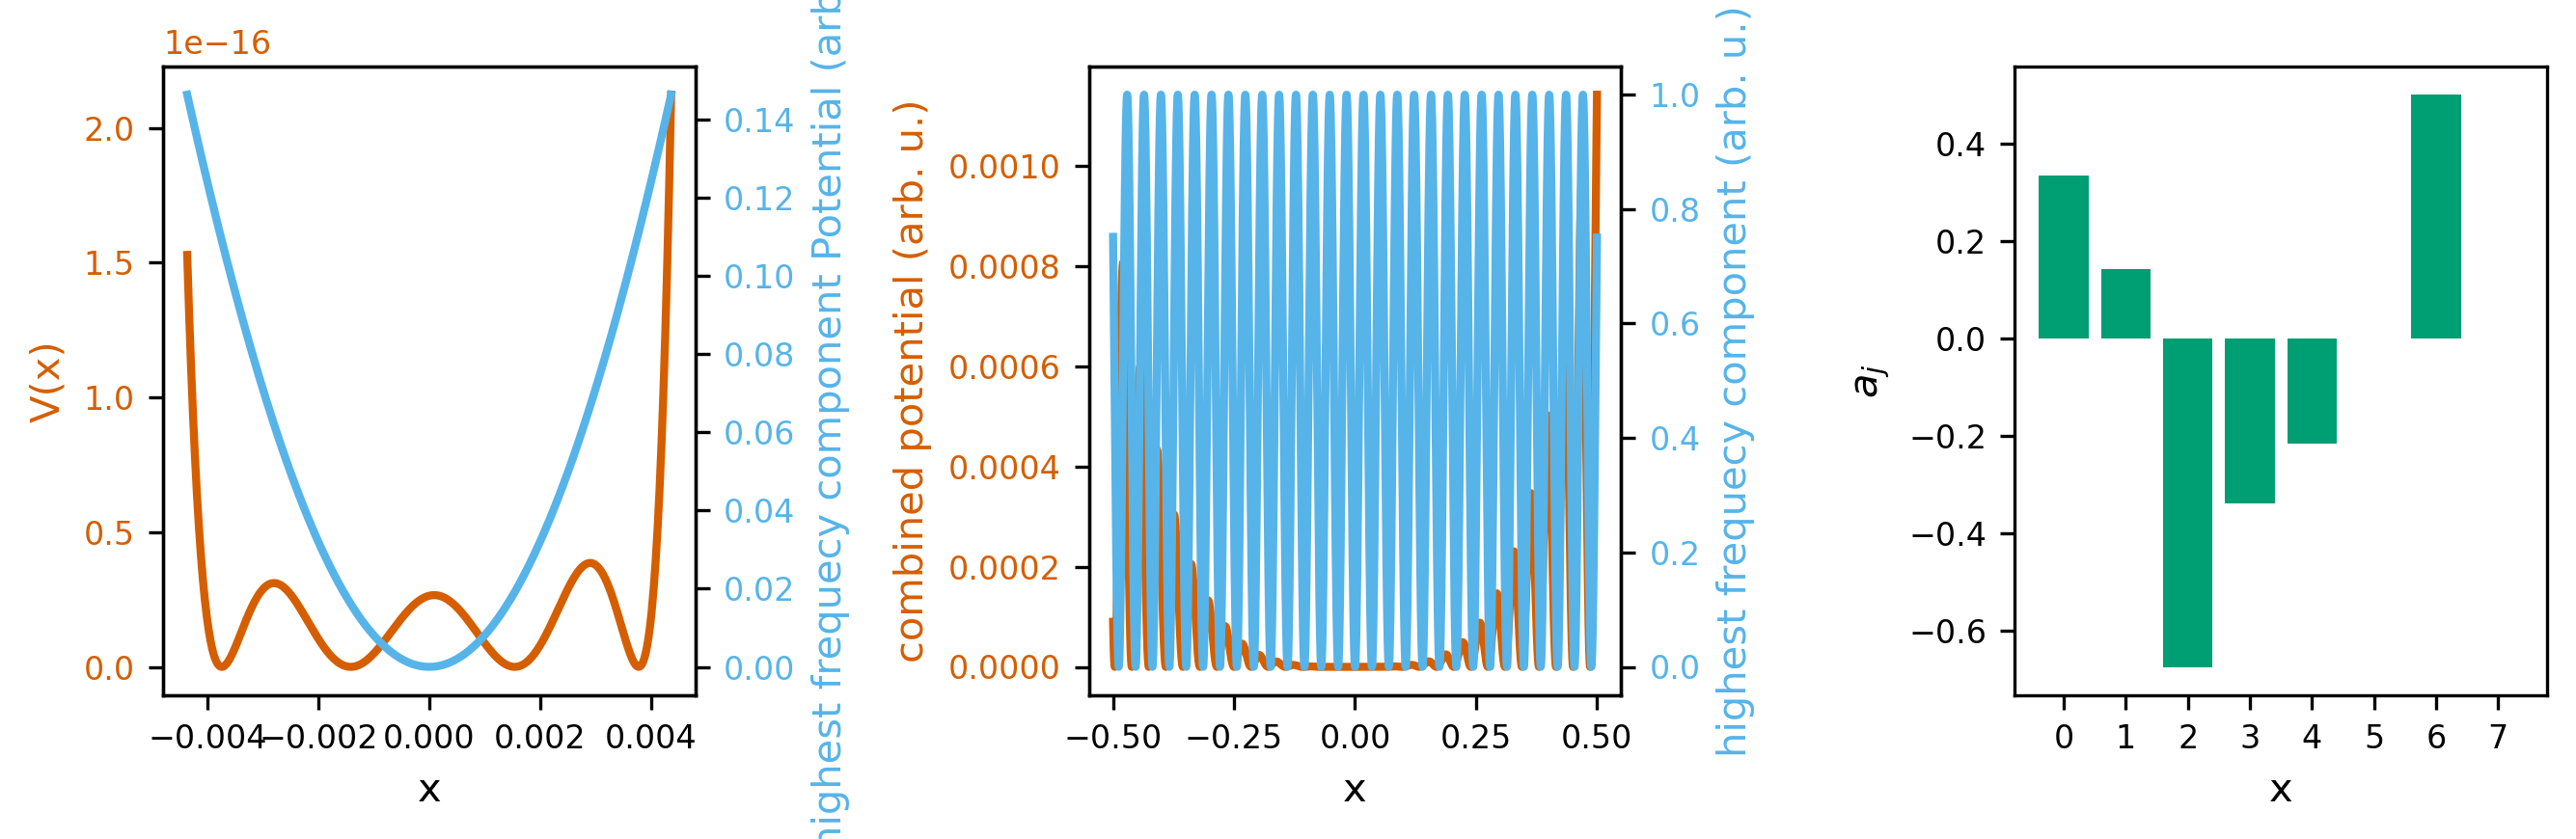

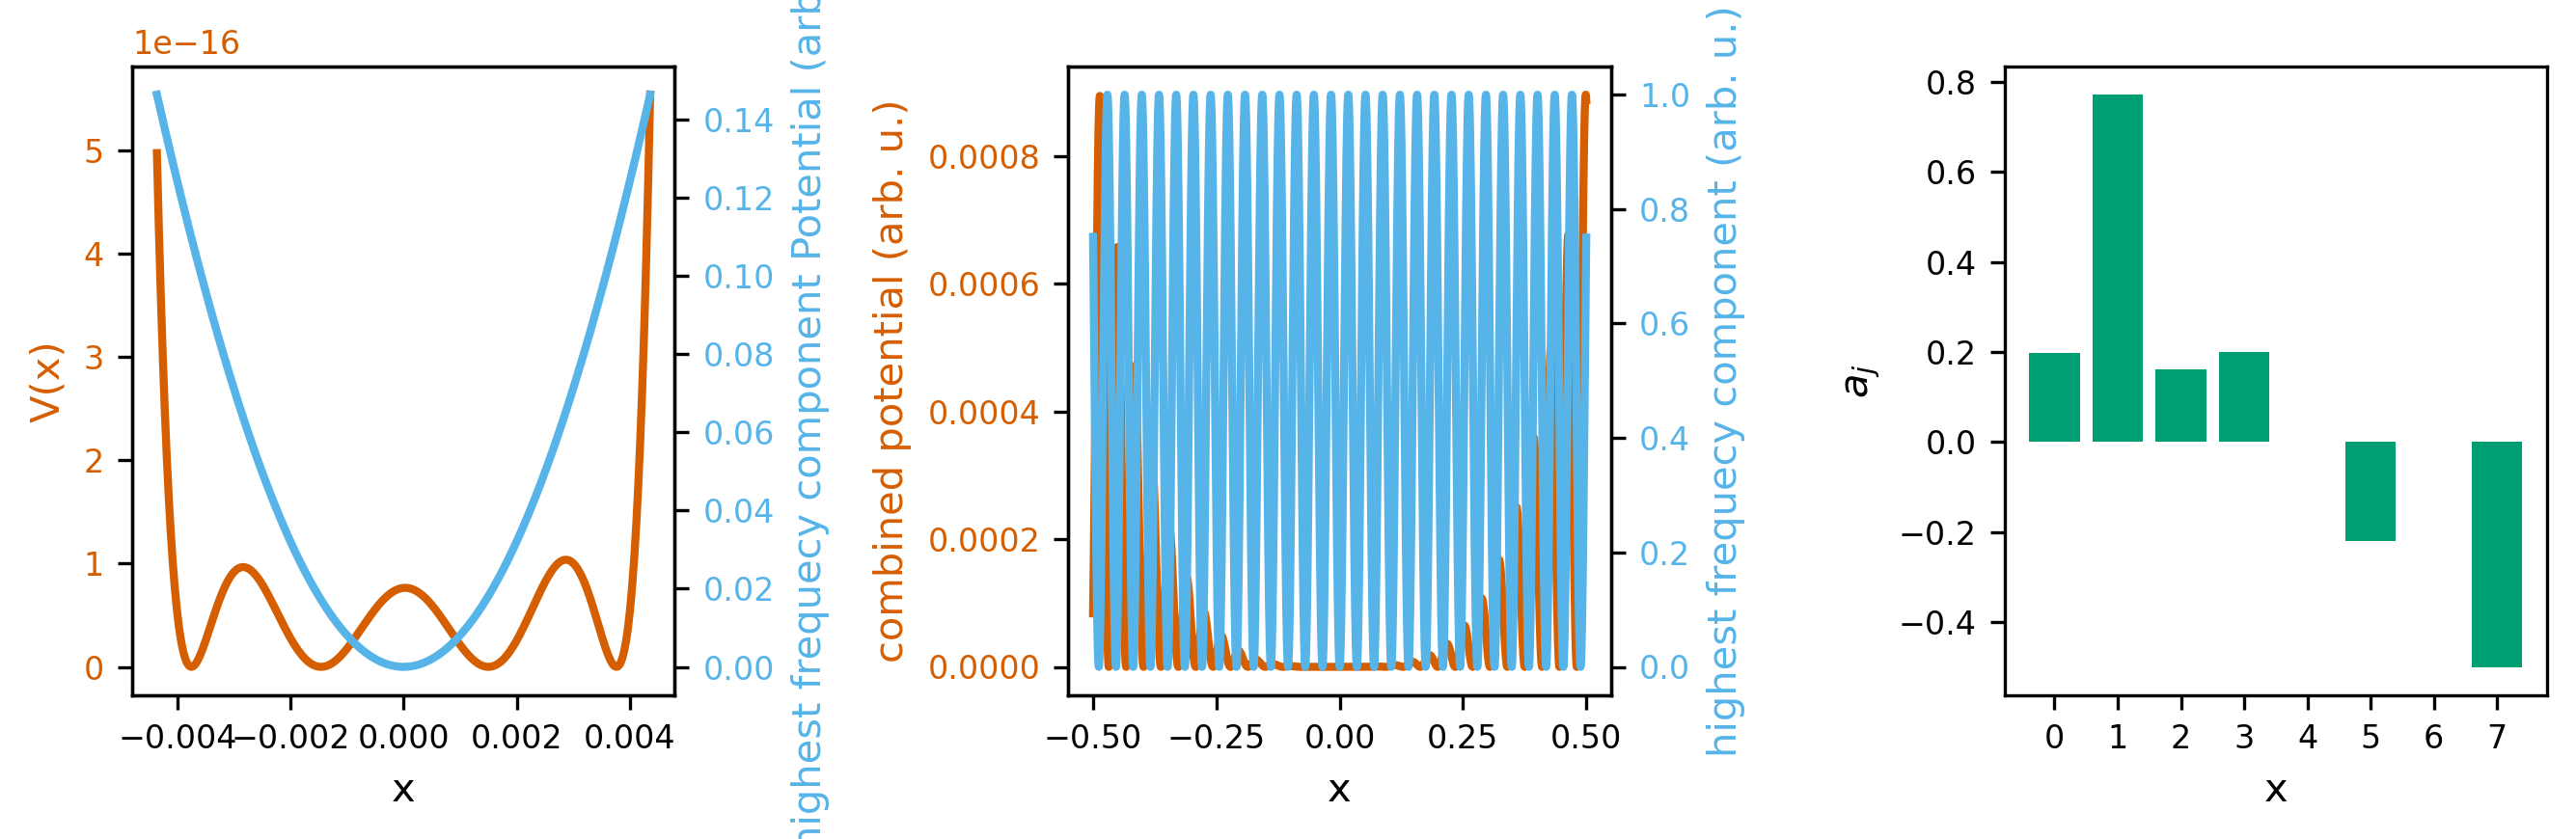

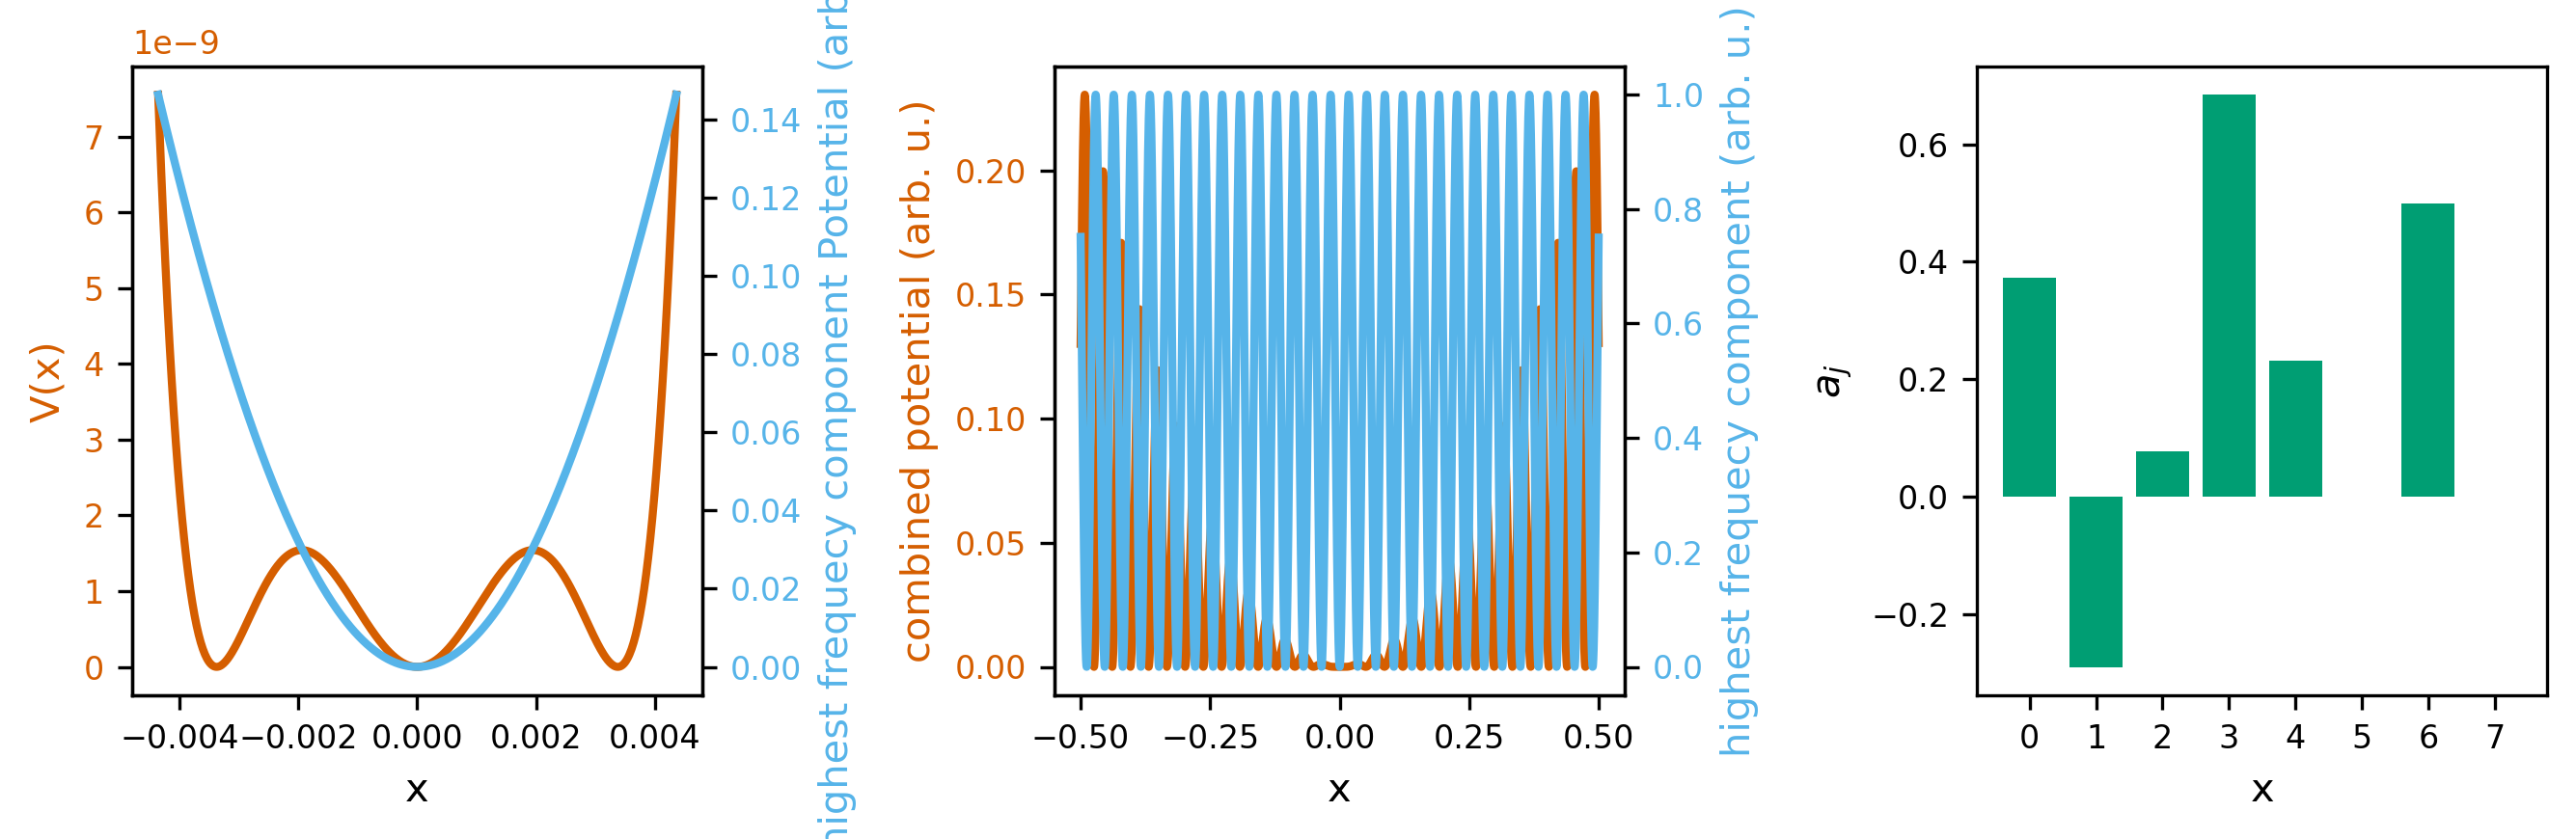

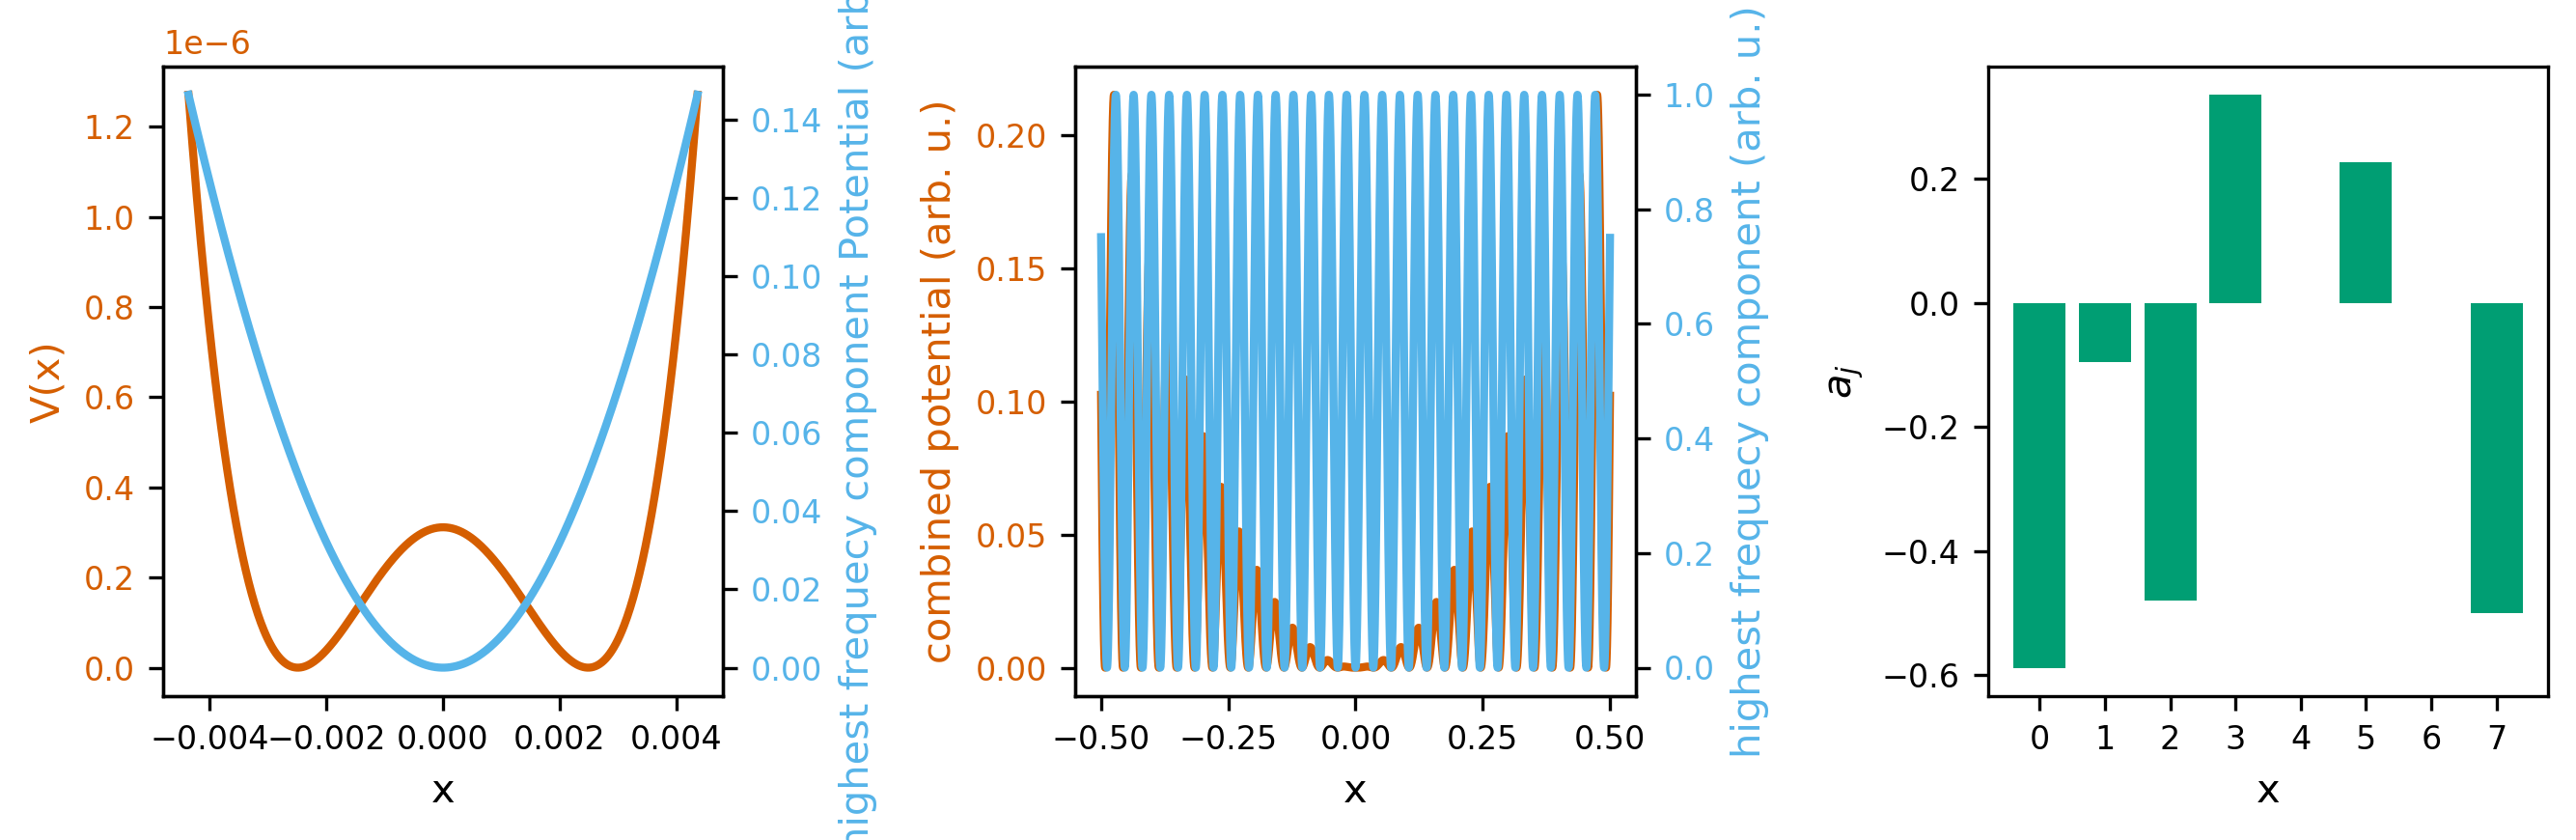

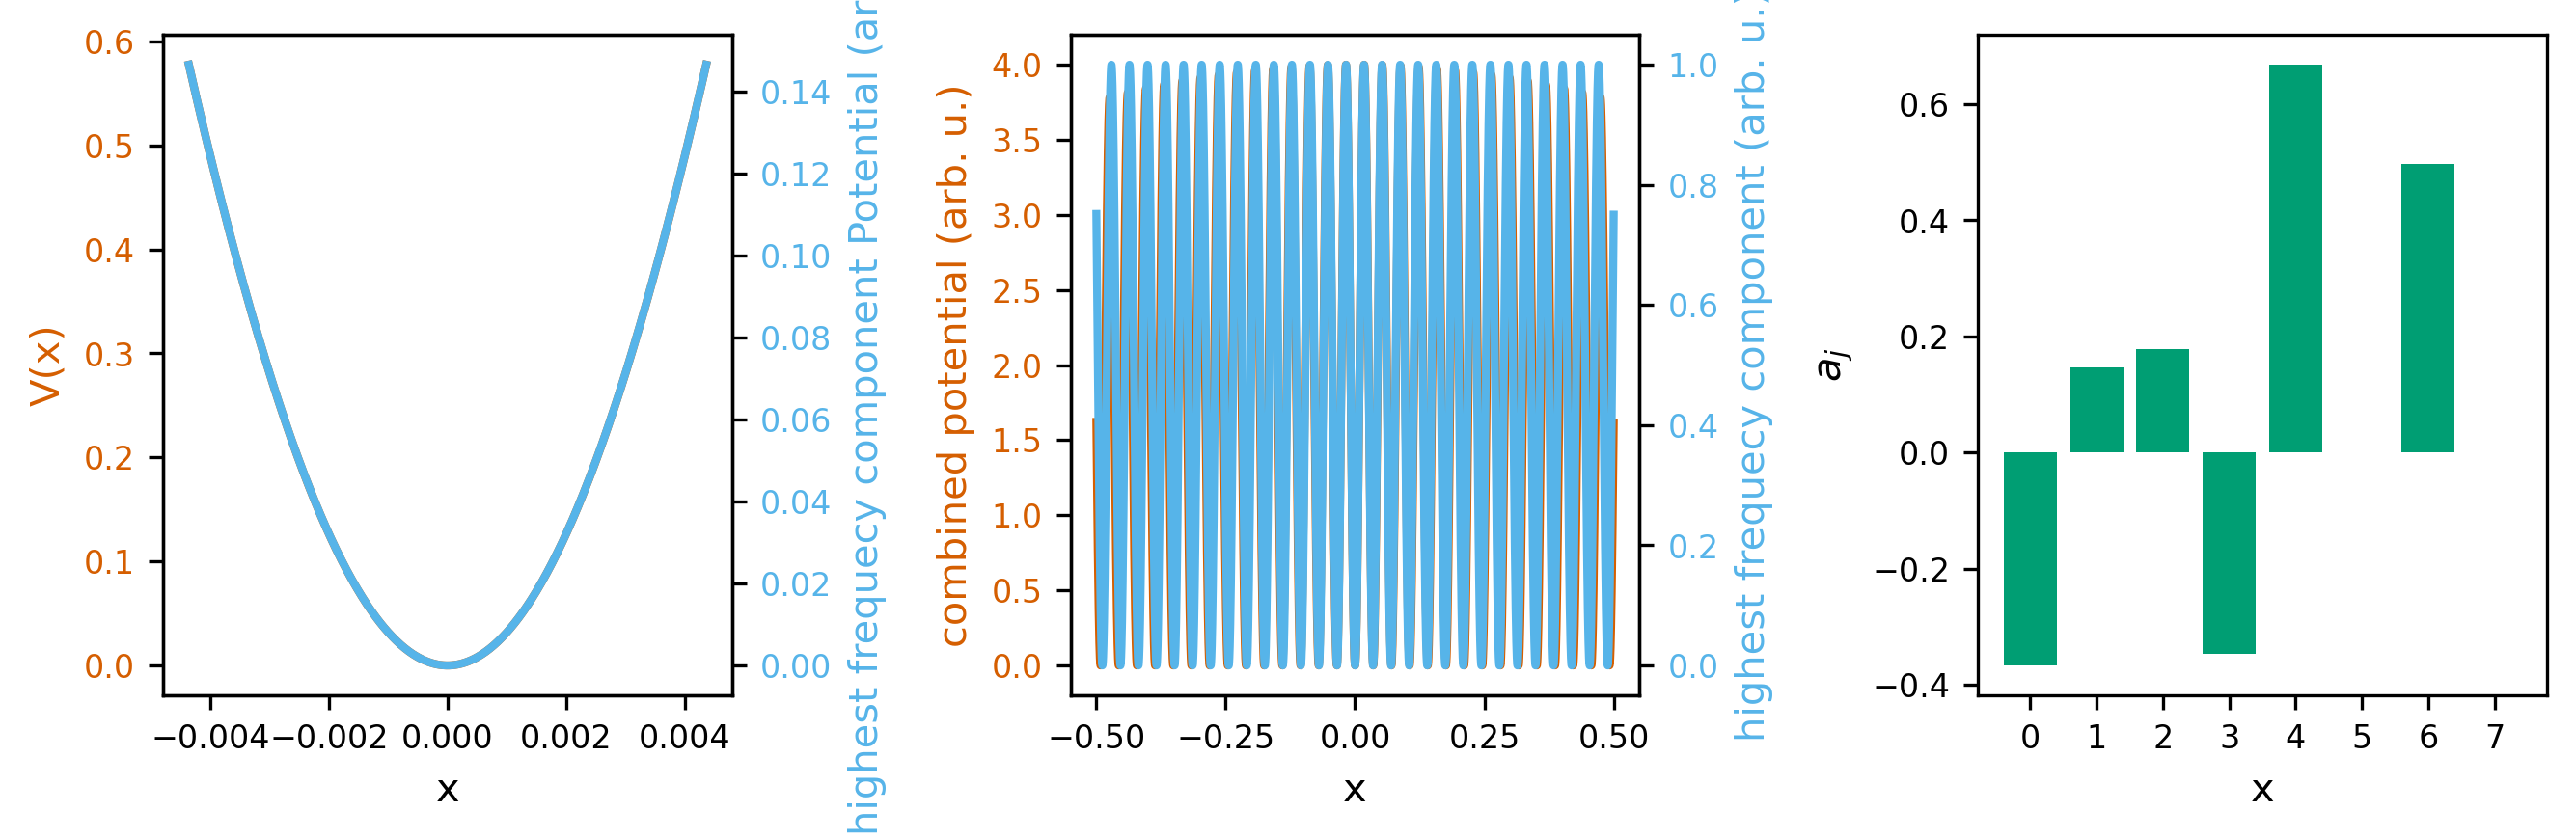

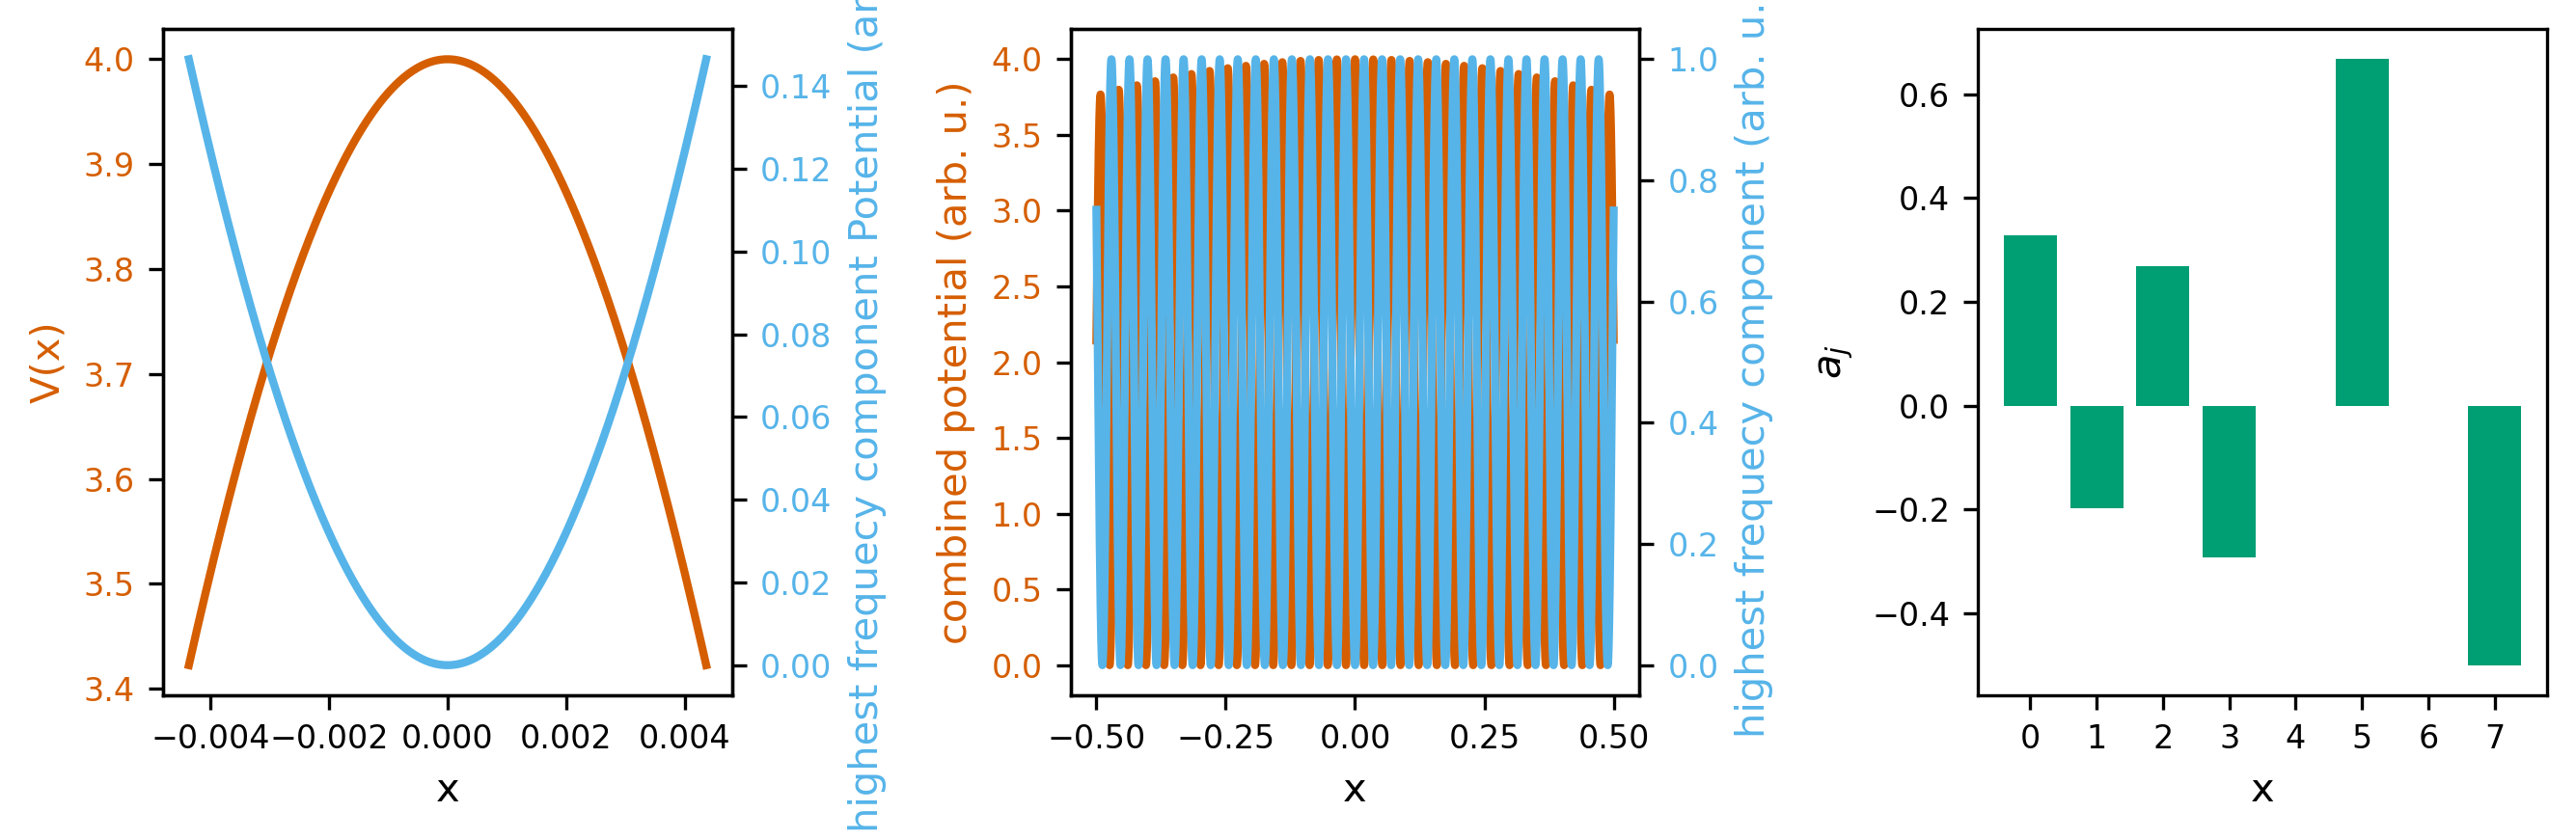

In [419]:
largest_freq_pulse = Phi(x, k_max)
largest_freq_pulsez = Phi(zoom_out_x, k_max)
for _ in range(0, n*2):
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
    eig_vector=vecs[:][_]
    
    color1 = ok['red']
    ax1.set_ylabel('V(x)', color=color1)
    ax1.plot(x, np.abs(eig_fields[_]) ** 2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set

    ax1.set_xlabel('x')
    
    ax2 = ax1.twinx() 
    
    color2 = ok['blue']
    ax2.set_ylabel('highest frequecy component Potential (arb. u.)', color=color2)
    ax2.plot(x, np.abs(largest_freq_pulse) ** 2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # plot zoom out view
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined potential (arb. u.)', color=color1)
    ax1.plot(zoom_out_x, np.abs(eig_fields_zoomout[_]) ** 2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('x')

    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(zoom_out_x, np.abs(largest_freq_pulsez) ** 2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color=ok['green'])
    ax1.set_xticks(np.arange(eig_vector.size))
    #ax1.set_xticklabels(λ_array, rotation='vertical')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()

plt.show()


In [420]:
#########################################################################
#
# After visually assessing optimal field, declare it here 
#
#########################################################################

eig_winner = eig_fields[1]
winner_zoom = eig_fields_zoomout[1]

# visual assesment modifier
vam = 8.5e3 #ampl * np.sqrt(5.5e5)
print(f'The multiplier to achieve desired amplitude is: {vam}')
print(vals * vam)

The multiplier to achieve desired amplitude is: 8500.0
[-7.50731184e-10  1.44950052e-10  3.32687324e-10  1.39061406e-09
  4.70301034e-03  1.09026435e+00  8.38442764e+05  1.61615561e+07]


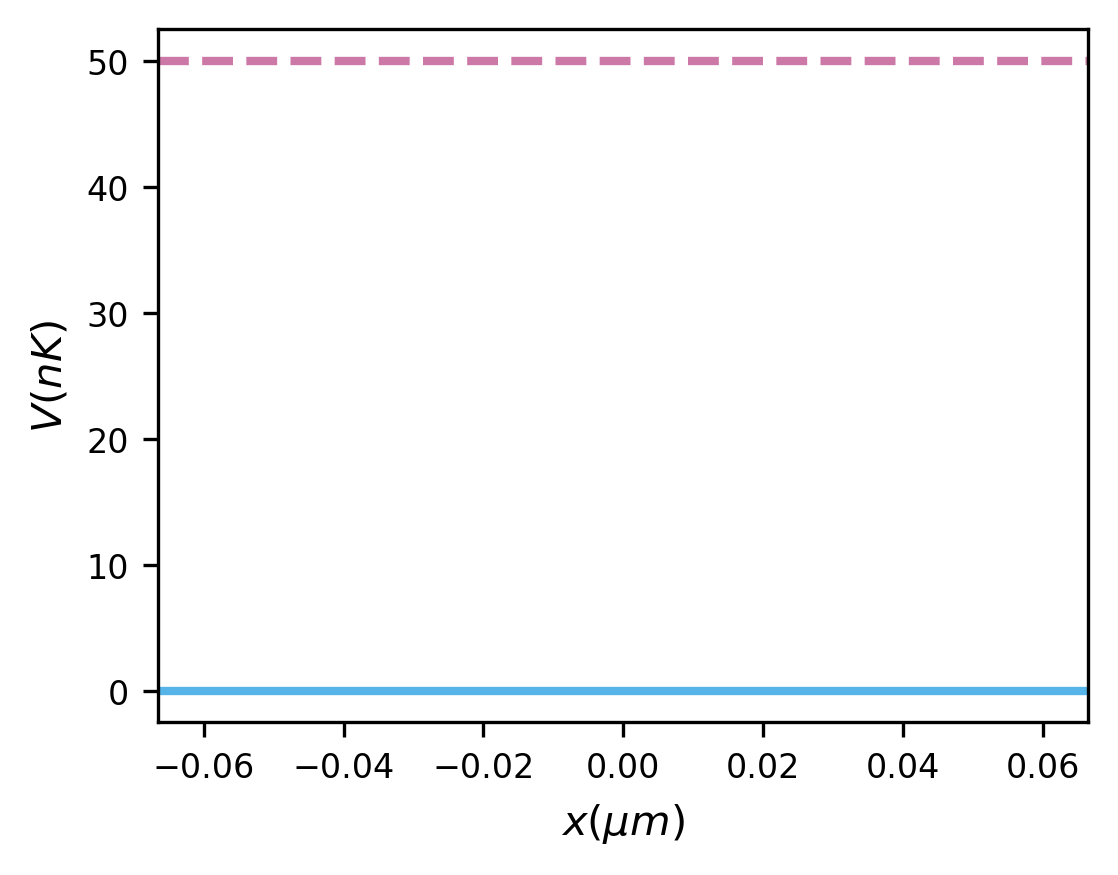

In [421]:
adjusted_eig_winner = vam * eig_winner
adjusted_eig_zoom = vam * winner_zoom
plt.hlines(gpe.convert_energy(ampl ** 2, -9), x_units[0], x_units[-1], color=ok['purple'], linestyle='--')
plt.plot(x_units, gpe.convert_energy(np.abs(adjusted_eig_winner) ** 2, -9))
plt.xlim(x_units[0], x_units[-1])
plt.xlabel('$x (\mu m)$')
plt.ylabel('$V (nK)$')
plt.savefig(f'{file_path}/{file_name}_EigenvectorSolution.pdf')
plt.show()

In [422]:
def get_local_freq(field, time):
    phase = np.unwrap(np.angle(hilbert(field)))
    return np.gradient(phase, np.pi / (time.max() - time.min()))


In [423]:
#trim_edges=1
#cut= slice(trim_edges,-trim_edges)
#best_fit_lf = get_local_freq(best_fit[cut], x[cut])
#target_lf = get_local_freq(target_barrier[cut], x[cut])
#plt.plot(x[cut], best_fit_lf, label='Best_fit')
#plt.plot(x[cut], target_lf, label='Target_Field')
#plt.xlim(-0.75/k, 0.75/k)
#plt.ylim(-0.01, 0.03)
#plt.legend()
#plt.show()


In [424]:
#def plot_spectrum(f, t, **kwargs):
#    """
#    Plot the High Harmonic Generation spectrum
#    """
#    # Power spectrum emitted is calculated using the Larmor formula
#    #   (https://en.wikipedia.org/wiki/Larmor_formula)
#    # which says that the power emitted is proportional to the square of the acceleration
#    # i.e., the RHS of the second Ehrenfest theorem

#    N = len(f)
#    K = np.arange(N)

#    # frequency range
#    omegas = (K - N / 2) * np.pi / (0.5 * t.max())

#    # spectra of the
#    spectrum = np.abs(
#        # used windows fourier transform to calculate the spectra
#        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
#        fftpack.fft((-1) ** K * blackman(N) * f)
#    ) ** 2
#    spectrum /= spectrum.max()
#    plt.semilogy(omegas / k, spectrum, **kwargs, label=get)
#    plt.ylabel('spectrum (arbitrary units)')
#    plt.xlabel(r'frequency / $\omega$')
#    plt.xlim([0, 20])
#    plt.ylim([1e-2, 1.])

#plt.figure()
#get = 'Target Barrier'
#plot_spectrum(target_barrier, x)
#get = 'test'
#plot_spectrum(best_fit, x)


#plt.legend()
#plt.tight_layout()
#plt.show()'''


In [425]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

#result_super.sort(key=lambda _: _[0])
#opt_vals = result_super[0][1]
#best_fit_super = phi_func(opt_vals, x)

#plt.plot(x, phi_func(opt_vals, x) ** 2, label='Prioritized Superscillations')
#plt.plot(x, (Phi(x, k_max) ** 2) * 1e-10, label='Highest Component Frequency (Scaled)')
#plt.xlabel('$x$')
#plt.ylabel('$V(x)$')
#plt.xlim(x[0], x[-1])
#plt.ylim(0, 1e-20)
#plt.legend()
#plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_Superoscillations.pdf')
##plt.savefig('./Plots/Presentation/Superoscillations.pdf')
#plt.show()


In [426]:
#plt.plot(zoom_out_x, phi_func(opt_vals, zoom_out_x) ** 2, label='Prioritized Superoscillations')
#plt.plot(zoom_out_x, Phi(zoom_out_x, k_max) ** 2 * 1e-6, label='Highest Component Frequency')
##plt.plot(x, target_barrier, label='Target Trap')
#plt.xlabel('$x$')
#plt.ylabel('$V(x)$')
#plt.xlim(zoom_out_x[0], zoom_out_x[-1])
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
#plt.legend()
#plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_SuperoscillationsZoomed.pdf')
##plt.savefig('./Plots/Presentation/SuperoscillationsZoomed.pdf')
#plt.show()


## Below is the BEC section. Please declare the field you wish to use.

In [427]:
########################################################################################################################
# The field goes here
########################################################################################################################
pre_cooling = False
test_field_full = best_fit_zoom
test_field_so_window = best_fit
#test_field_full = adjusted_eig_zoom
#test_field_so_window = adjusted_eig_winner

test_field_tag = 'BestFit'
#test_field_tag = 'SKLearnLinReg'
#test_field_tag = 'EigenvectorSolution'

# Coordinates are declared as z for ease of reading
# Coordinate x is still used when viewing SO window
dz = dx
z = zoom_out_x
T = 50
times = np.linspace(0, T, 500)

# Potentials as "functions"
VV = UnivariateSpline(z, (np.abs(test_field_full) ** 2), s=0)
vv = UnivariateSpline(x, (np.abs(test_field_so_window) ** 2), s=0)



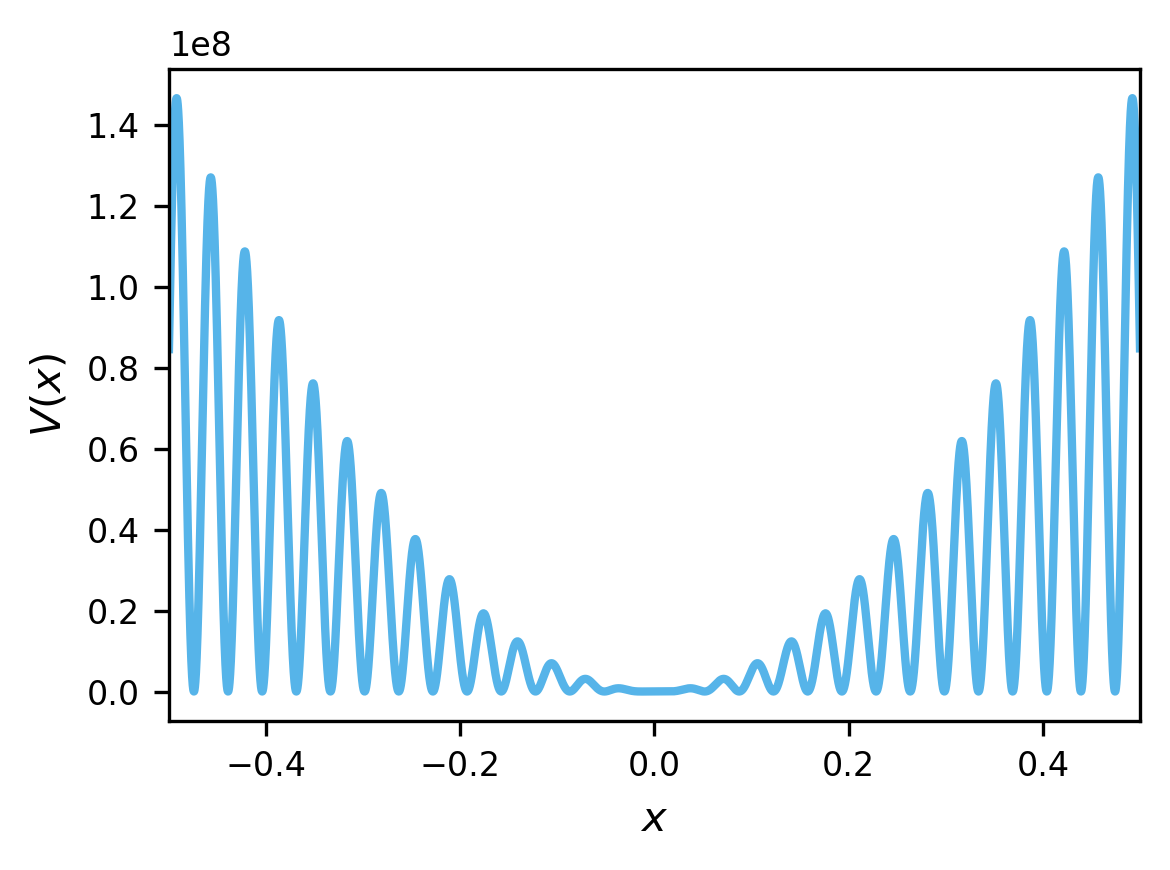

In [428]:
########################################################################################################################
# Get the BEC
########################################################################################################################



@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope = 1 # 1 / (2 * np.pi)
suggestion_sin = Phi(z, np.pi / (2 * x_lim), amplitude=2*ampl) ** 2

@njit(parallel=True)
def first_pass_cooling(x):
    """
    Non-relativistic kinetic energy
    """
    return (((0.25 * ampl ** 2) * x) / x_lim) ** 2


first_pass_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=first_pass_cooling,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=VV,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

if pre_cooling:
    plt.plot(z, first_pass_cooling(z), label='Initial Cooling Potential')
plt.plot(z, sys_params['initial_trap'](z), label='SO Potential')
plt.xlabel('$x$')
plt.ylabel('$V(x)$')
plt.xlim(z[0], z[-1])
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential_{test_field_tag}.pdf')
plt.show()

In [429]:
#init_state, E, mu = imag_time_gpe1D(
#    v=first_pass_params['initial_trap'],
#    g=g,
#    dt=1e-6,
#    epsilon=1e-8,
#    **sys_params
#)

#init_state, E, mu = imag_time_gpe1D(
#    v=first_pass_params['initial_trap'],
#    g=g,
#    init_wavefunction=init_state,
#    dt=1e-8,
#    epsilon=1e-10,
#    **sys_params
#)
#
#print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
#print(f'Initial State Chemical Potential:  {gpe.convert_energy(mu, -9)} nK')

In [430]:
#print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
#density = np.abs(init_state) ** 2 * dz
#print(f'Sanity Check, the density is: {np.sum(density)}')
#plt.plot(z, density)
#plt.xlim(z[0], z[-1])
#plt.show()

In [431]:
init_state, E, mu = imag_time_gpe1D(
    #init_wavefunction=init_state,
    v=sys_params['initial_trap'],
    g=g,
    dt=1e-6,
    epsilon=1e-8,
    **sys_params
)

init_state, E, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-8,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
print(f'Initial State Chemical Potential:  {gpe.convert_energy(mu, -9)} nK')


Starting imaginary time propagation
current ground state energy = 2.5637e+05


Final current ground state energy = 6.3490e+03
Final Chemical potential = 7.5474e+03

Starting imaginary time propagation
current ground state energy = 6.3490e+03


Final current ground state energy = 6.3490e+03
Final Chemical potential = 7.5475e+03
Initial BEC Energy: 152.35083257351462 nK
Initial State Chemical Potential:  181.11162269146314 nK


Initial State Chemical Potential: 181.11162269146314 nK


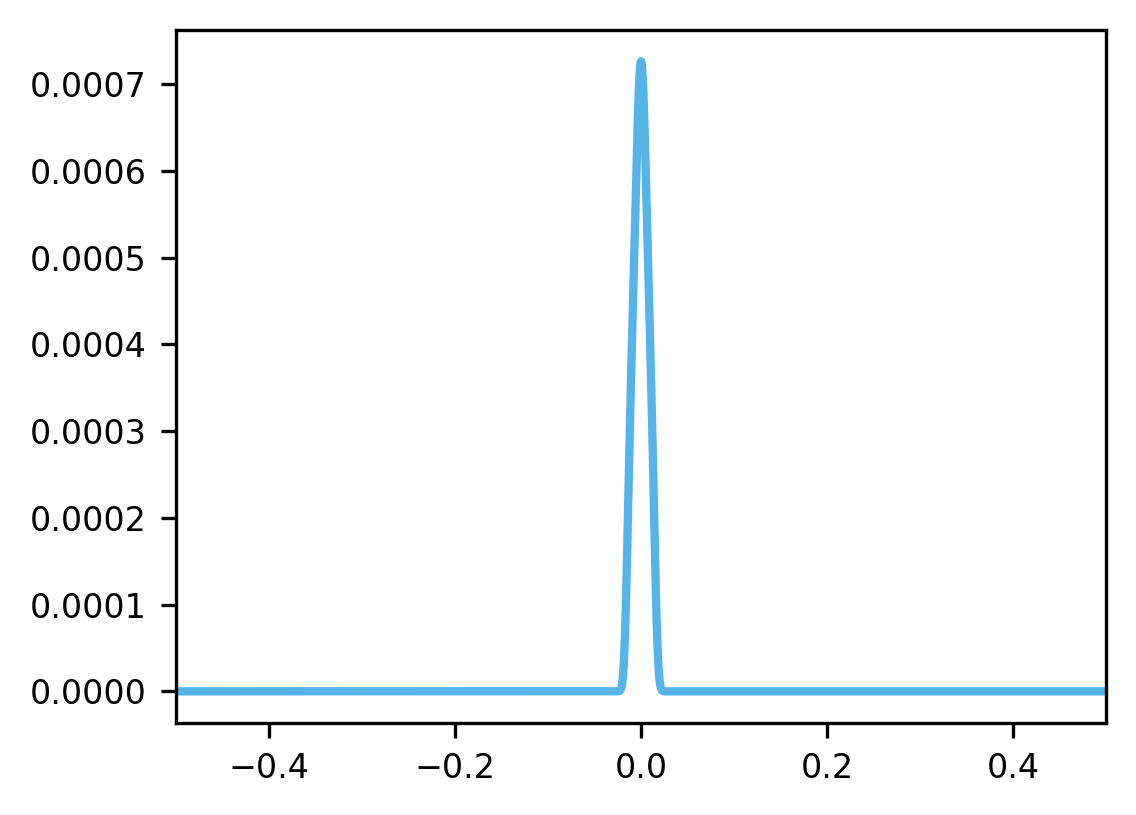

Sanity Check, the density is: 1.0000000000000004


In [432]:
print(f'Initial State Chemical Potential: {gpe.convert_energy(mu, -9)} nK')
density = np.abs(init_state) ** 2 * dz
plt.plot(z, density)
plt.xlim(z[0], z[-1])
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

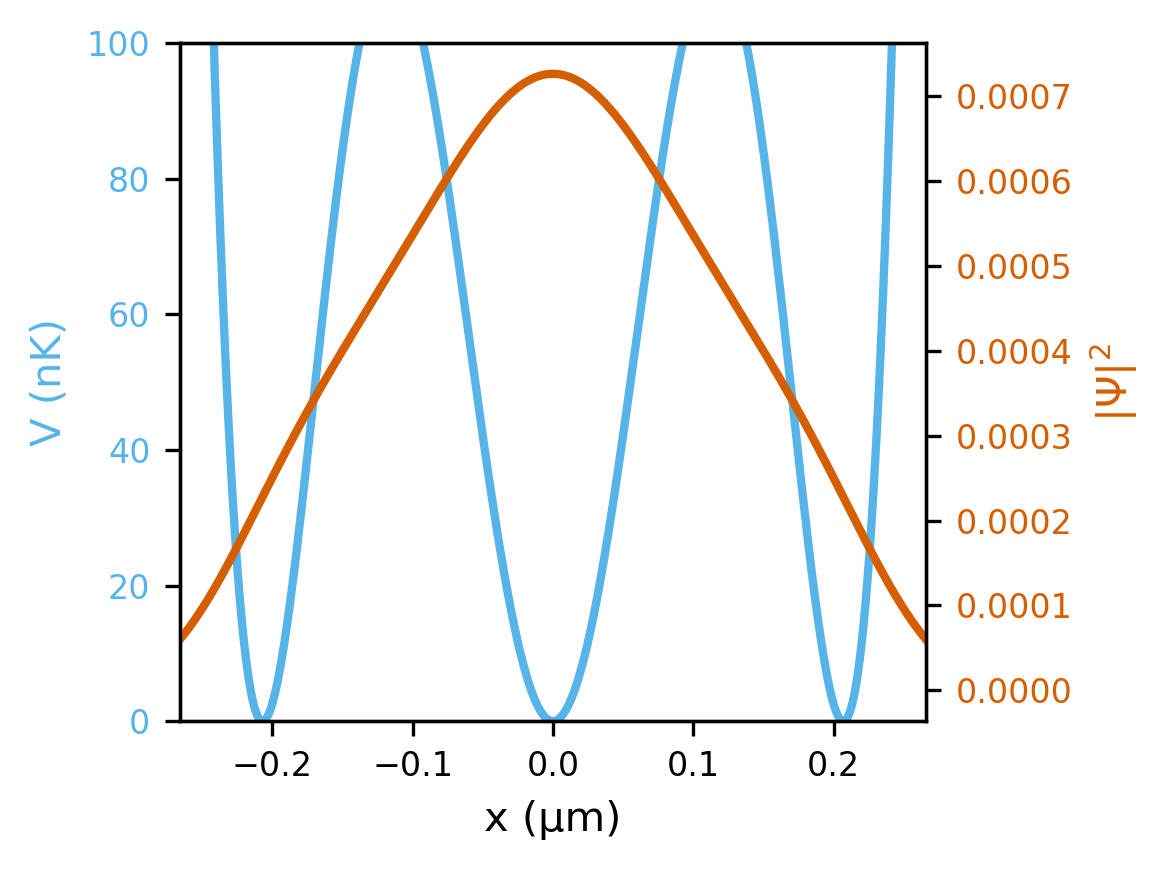

In [433]:
fig=plt.figure()
phys_potential = gpe.convert_energy(sys_params['initial_trap'](z), -9)
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -6), phys_potential, color=ok['blue'])
ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(-2*np.pi/k, -6), gpe.convert_x(2*np.pi/k, -6), linestyle='--', color=ok['navy'])
ax1.set_xlabel('x (μm)')
ax1.set_xlim(gpe.convert_x(-2*np.pi/k, -6), gpe.convert_x(2*np.pi/k, -6))
ax2=ax1.twinx()
ax2.plot(gpe.convert_x(z, -6), density, color=ok['red'])
#ax2.plot(gpe.convert_x(x, -6), UnivariateSpline(gpe.convert_x(z, -6), density, s=0)(gpe.convert_x(x, -6)), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, gpe.convert_energy(2*ampl**2, -9))
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_{test_field_tag}.pdf')
plt.show()


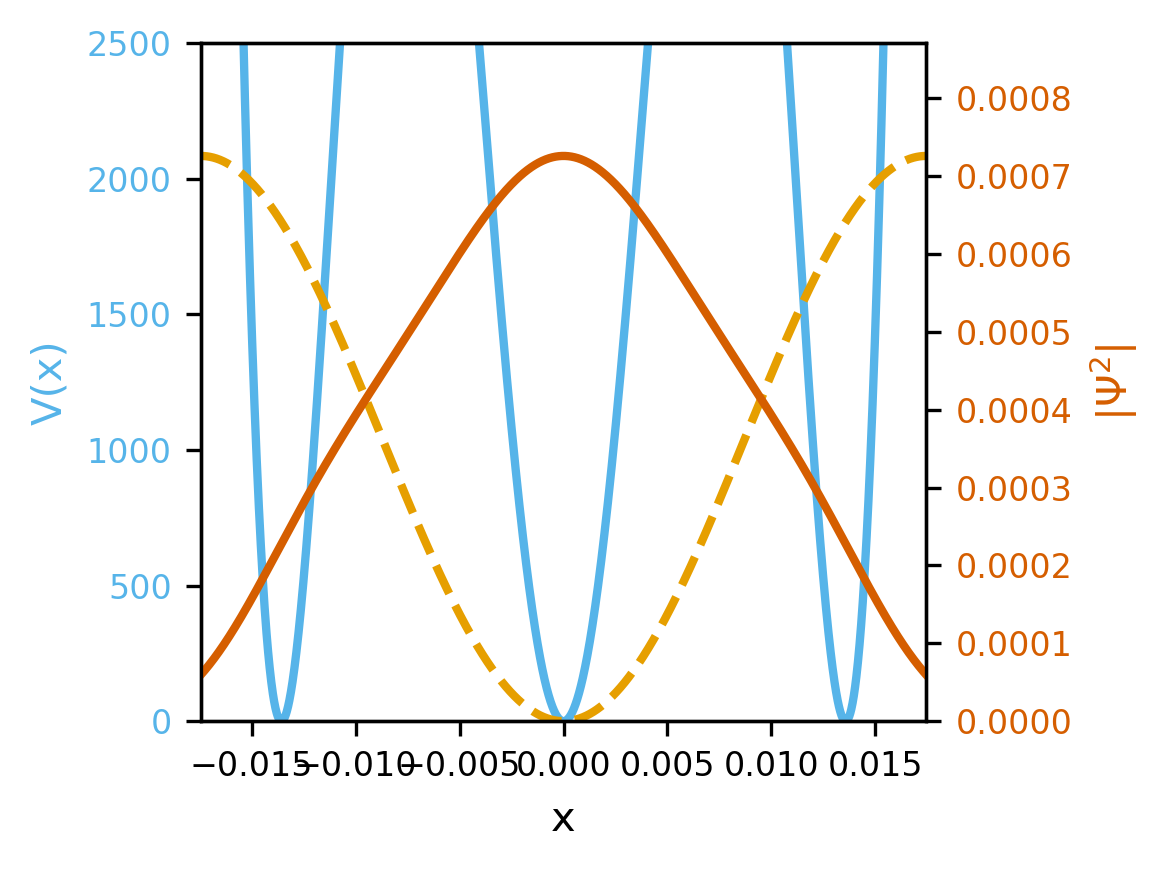

In [434]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])
ax1.set_xlabel('x')
ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, 1.2*ampl**2)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped_{test_field_tag}.pdf')
#plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped.png')
plt.show()

In [435]:
#density_func = UnivariateSpline(z, density, s=0)
#n_peaks = 2
#peak_spacing = 2 * λ / n_peaks
#peaks_sectioning = np.linspace(-λ, -λ+(n_peaks-1)*peak_spacing, n_peaks)


#interest_areas = [(np.array(z)[(z>=_) & (z<(_+peak_spacing))]) for _ in peaks_sectioning]
#peak_locations = [_[density_func(_).argmax()] for _ in interest_areas]
#confinement_distance = [np.abs(peak_locations[_+1]-peak_locations[_]) for _ in range(len(peak_locations)-1)]
#print(f'Peaks are located at: {peak_locations}')
#print(f'Distances between these peaks are: {confinement_distance}')
#print(f'The confinement limit is half the field wavelength: {0.5 * λ_min}')
#print(f'The confinement limit is half the potential wavelength: {0.25 * λ_min}')

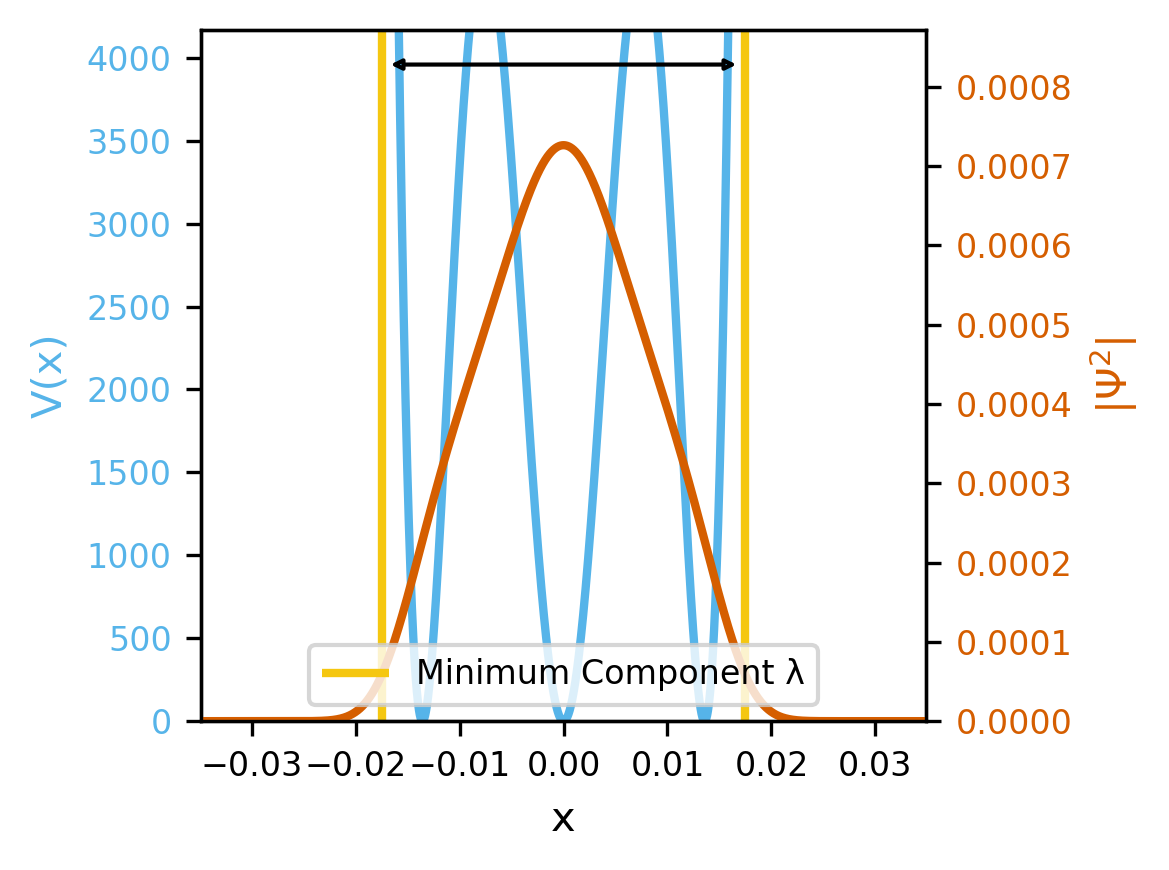

In [436]:
plot_max = 2 * ampl ** 2    

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, k_max, amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])

ax1.vlines([-λ_min/4, λ_min/4], 0, plot_max, color=ok['amber'], label='Minimum Component λ')
#ax1.vlines(peak_locations, 0, plot_max, color=ok['grey'], label='Density Peak spacing')

ax1.add_patch(patches.FancyArrowPatch((-λ_min/4, 0.95*plot_max), (λ_min/4, 0.95*plot_max), arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
#for _ in range(n_peaks-1):
#    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5))
ax1.set_xlabel('x')
ax1.set_xlim(-4*np.pi/k, 4*np.pi/k)
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
legend1 = ax1.legend(loc='lower center')
legend1.remove()
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
ax2.add_artist(legend1)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo_{test_field_tag}.pdf')
plt.show()

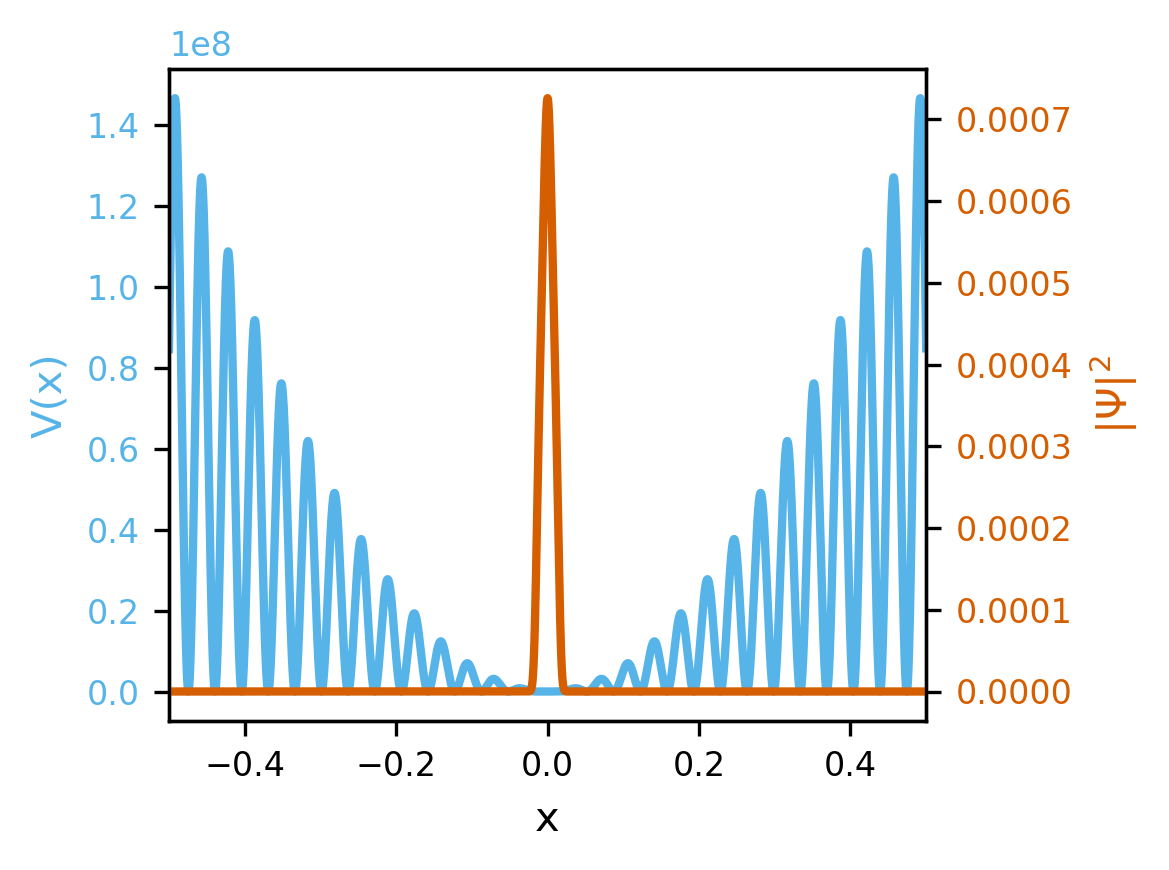

In [437]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_{test_field_tag}.pdf')
plt.show()

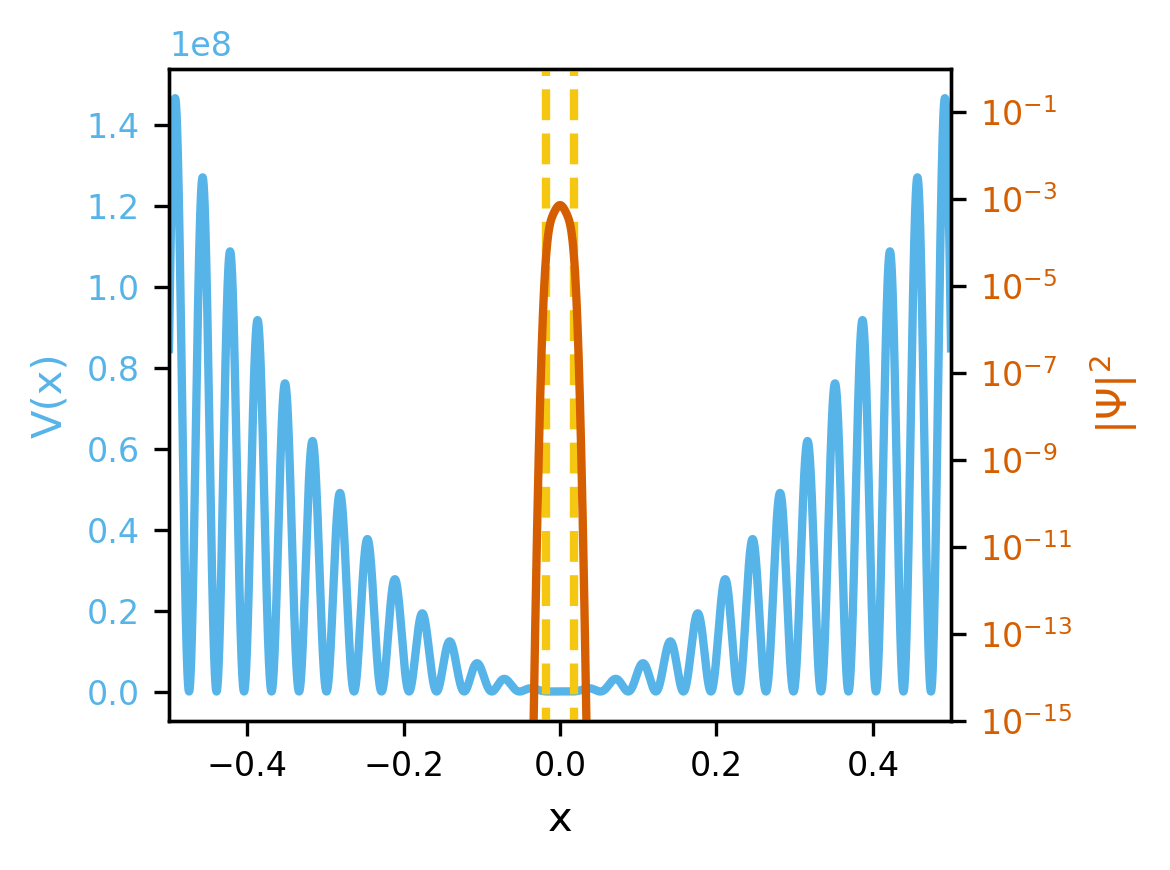

In [438]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.vlines([-λ_min/4, λ_min/4], 0, 1, color=ok['amber'], linestyle='--')
ax2.semilogy(z, density, color=ok['red'])
ax2.set_ylim(10**-15, 1)
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_semilogy_{test_field_tag}.pdf')
plt.show()

In [439]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The confinement limit is half the field wavelength: {0.5 * λ_min}')
print(f'The confinement limit is the halved potential wavelength: {λ_min/4}')

The variance is 6.184083043990208e-05
The confinement limit is half the field wavelength: 0.0348823604157883
The confinement limit is the halved potential wavelength: 0.01744118020789415


In [440]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The confinement limit is the halved potential wavelength: {λ_min/4}')

The variance is 6.184083043990208e-05
The confinement limit is the halved potential wavelength: 0.01744118020789415


In [441]:
print(f' wavelengths are : {[np.round(gpe.convert_x(_,-9), 2) for _ in λ_array]} nm')

 wavelengths are : [1064.0, 1069.32, 1074.64, 1079.96] nm
